# Optimized Kalman Filters Analysis

This notebook demonstrates the power of Kalman Filters with optimized parameters.
In other words, instead of determining $R$ and $Q$ by estimation from data, we determine them by direct optimization of MSE (along with the auxillary loss NLL) wrt $R,Q$, using gradient-descent (or more accurately, ADAM).

We define several scenarios and several variant of KF.
For each scenario and for each KF variant, we train the model on the training data of the scenario - once by estimating $R,Q$ and once by optimizing them. Then we test on the scenario's test data.
In other words, the parameters are determined in an offline manner, and once they are, the whole tracker is indistinguishable from any standard KF.

We demonstrate that:
1. **When using a "standard" KF, we actually have several non-trivial degrees of freedom** (e.g. KF vs. EKF, and coordinates of $R$) that sometimes have significant effect on the accuracy.
2. **Optimized KF achieves better MSE** than estimated KF for almost any scenario and any variant of KF.
3. Optimization is usually more beneficial when the variant of KF is poorly-chosen. Hence, **optimization makes the performance less sensitive to the chosen configuration of the KF**.
4. Optimized KF seems to usually do better when generalizing to different scenarios, though this result is not definite.

In addition, initial results indicate that both $R$ and $Q$ are important to optimize - optimization of either of them without the other results in somewhat reduced performance.

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB
import ScenarioSimulator as ssim

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Configurate scenarios & models

#### Scenarios

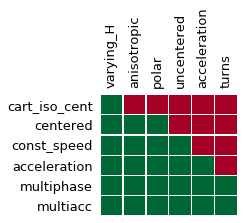

In [3]:
scenarios_meta_args = ssim.SCENARIOS_META_ARGS
ssim.show_meta_args_summary(scenarios_meta_args, utils.Axes(1,1,(3.5,3.2))[0],
                            cols=['varying_H', 'anisotropic', 'polar', 'uncentered', 'acceleration', 'turns']);
plt.tight_layout();

**Basic scenarios properties:**
- **varying_H**: the observation operator $H$ depends on target position.
- **anisotropic**: horizontal motion is more likely than vertical.
- **polar**: Radar detection noise is defined in polar coordinates (as in a real Radar system).
- **uncentered**: targets trajectories are not necessarily concentrated close to the location of the Radar.
- **acceleration**: target speed is not necessarily constant.
- **turns**: motion is not necessarily straight.

**Models** (estimated/optimized params; extended/standard KF; polar/cartesian representation of $R$):

In [4]:
models_args = (
    dict(load=False, title='KF', no_acc=True),
    dict(load=False, title='OKF', no_acc=True, const_Q=False, const_R=False),
    dict(load=False, title='KF_pol', no_acc=True, polar_R=True),
    dict(load=False, title='OKF_pol', no_acc=True, const_Q=False, const_R=False, polar_R=True),
    dict(load=False, title='EKF', no_acc=True, EKF=True),
    dict(load=False, title='OEKF', no_acc=True, const_Q=False, const_R=False, EKF=True),
    dict(load=False, title='EKF_pol', no_acc=True, EKF=True, polar_R=True),
    dict(load=False, title='OEKF_pol', no_acc=True, const_Q=False, const_R=False, polar_R=True, EKF=True),
)

model_names = [a['title'] for a in models_args]

gc.collect()

2230

# Generate scenarios


cart_iso_cent
['train', 'test']
Generating scenario train... done.	(15 [s])
Generating scenario test... done.	(5 [s])
1500 1500 (19, 4) (19, 6) 13.0 65.0 Counter({'00<acc<00': 1500})
{'max_acc': 0, 'time': 24.0}
   phase      mode  time  acc   direct  angle
0      0  straight    25  0.0  forward      0

centered
['train', 'test']
Generating scenario train... done.	(15 [s])
Generating scenario test... done.	(5 [s])
1500 1500 (19, 4) (19, 6) 13.0 65.0 Counter({'00<acc<00': 1500})
{'max_acc': 0, 'time': 24.0}
   phase      mode  time  acc   direct  angle
0      0  straight    25  0.0  forward      0

const_speed
['train', 'test']
Generating scenario train... done.	(13 [s])
Generating scenario test... done.	(4 [s])
1500 1500 (18, 4) (18, 6) 11.0 86.0 Counter({'00<acc<00': 1500})
{'max_acc': 0, 'time': 24.0}
   phase      mode  time  acc   direct  angle
0      0  straight    25  0.0  forward      0

acceleration
['train', 'test']
Generating scenario train... done.	(13 [s])
Generating scena

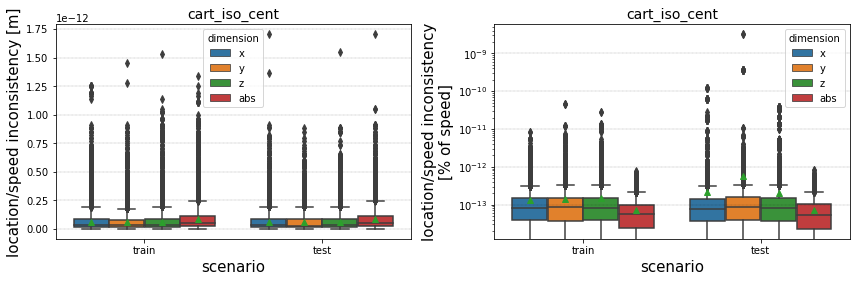

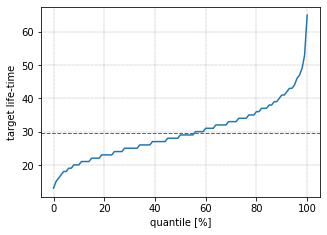

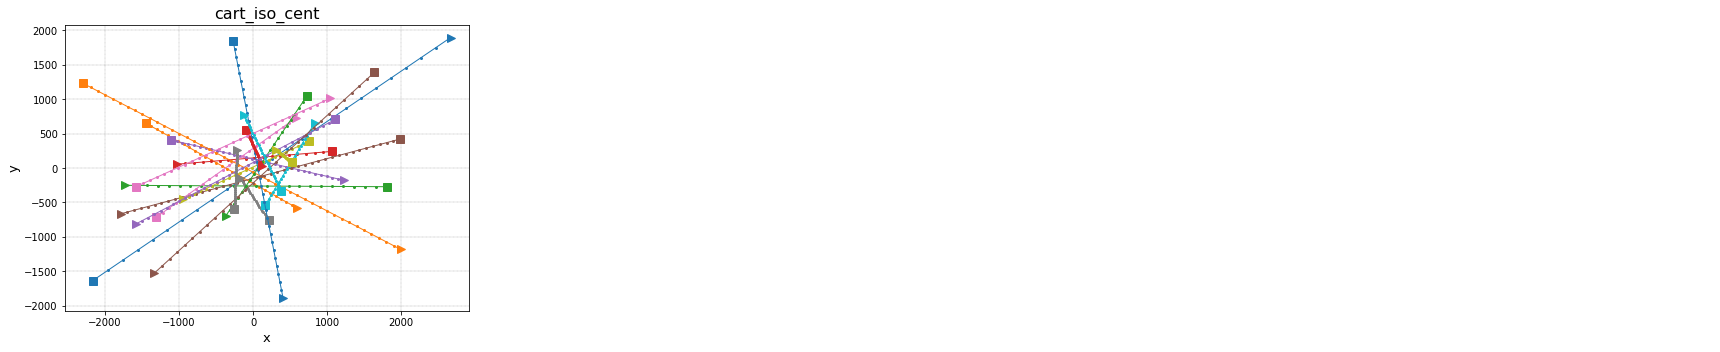

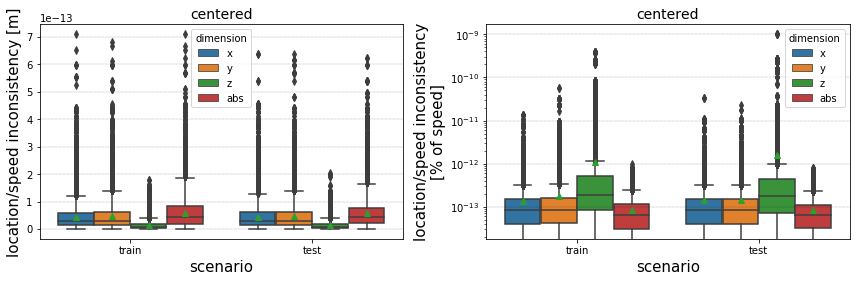

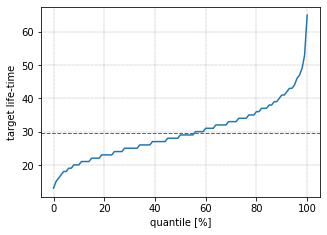

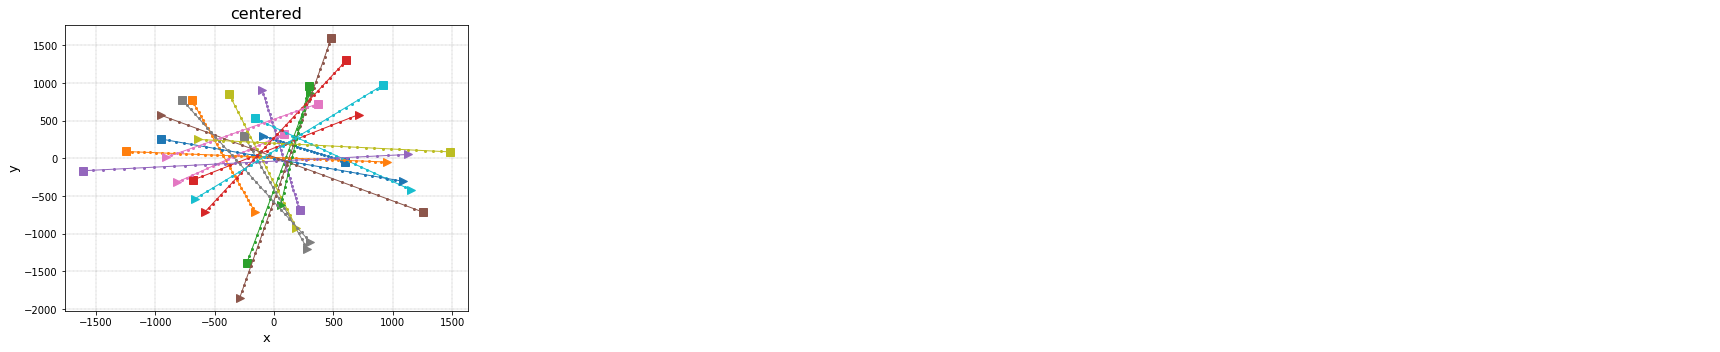

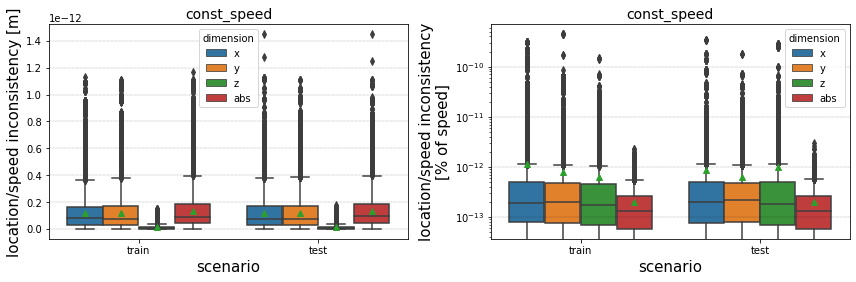

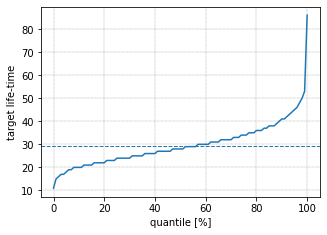

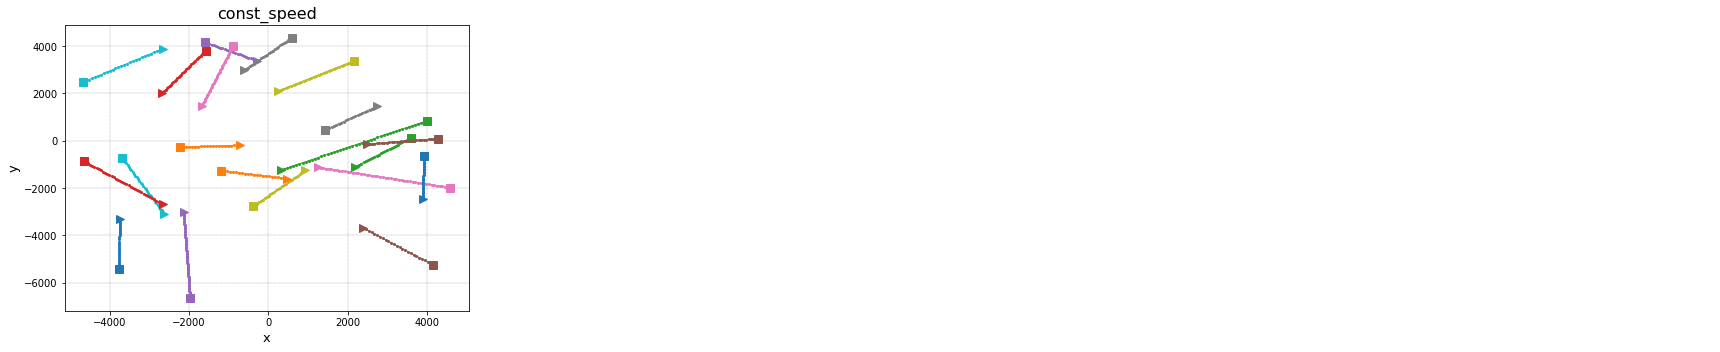

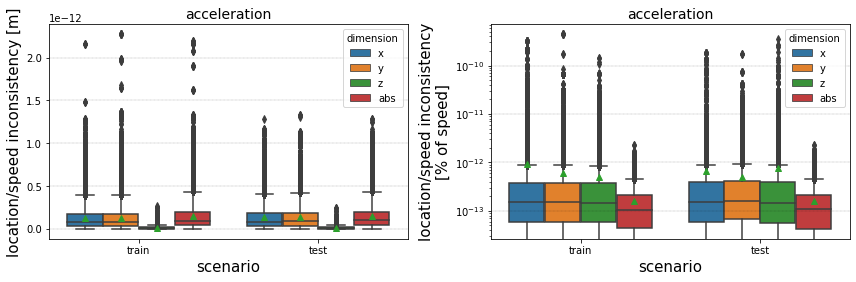

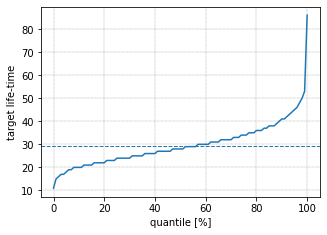

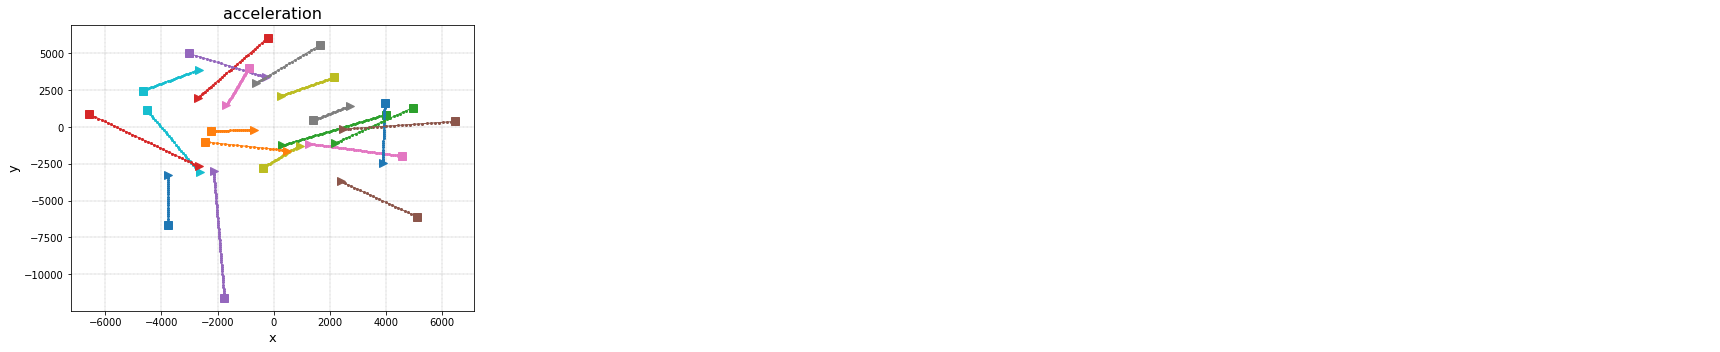

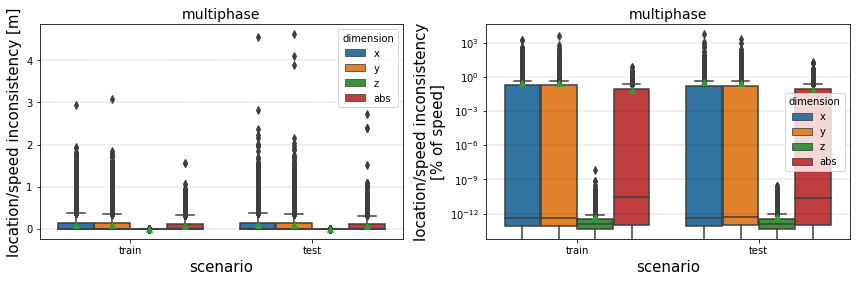

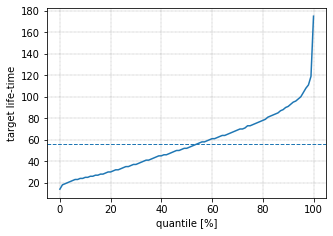

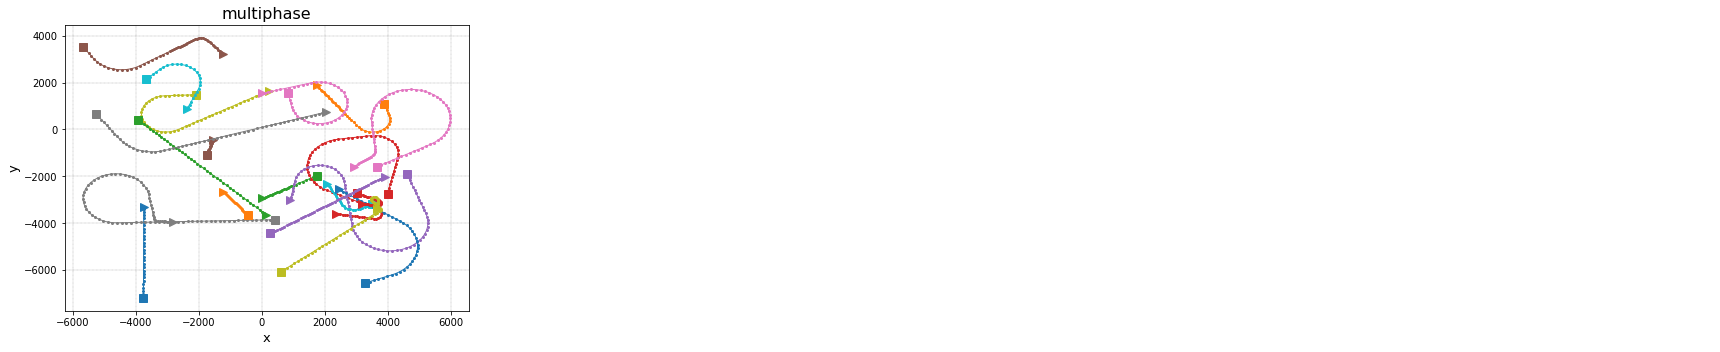

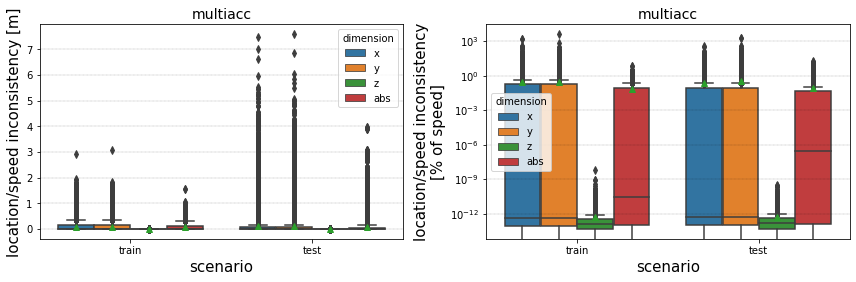

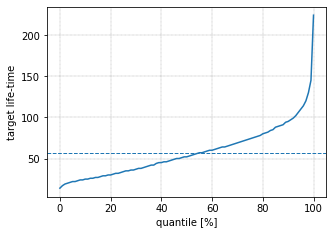

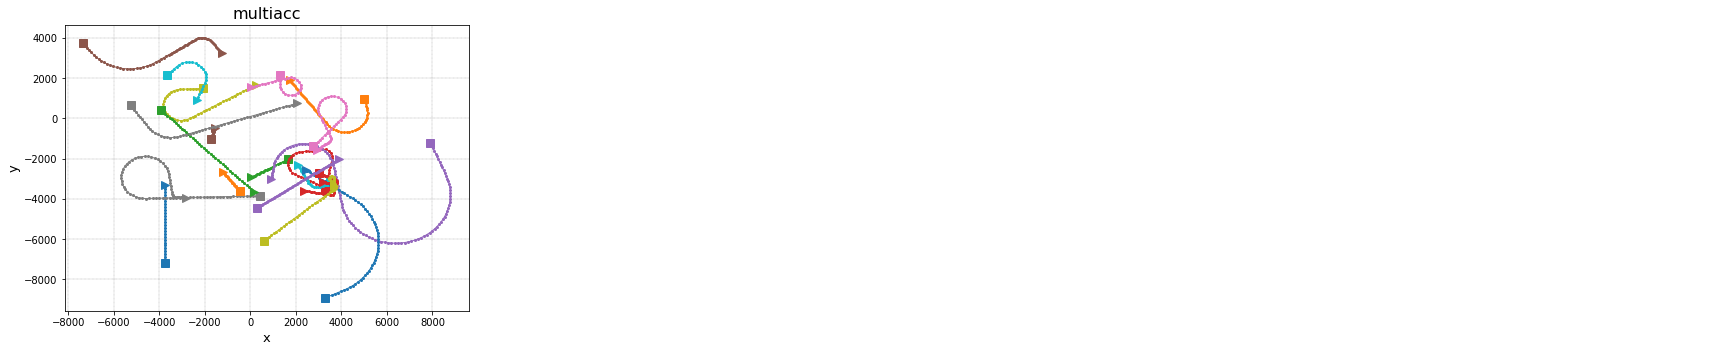

In [7]:
%time scenarios_args = ssim.generate_scenarios(meta_args=scenarios_meta_args)

#### Some properties of the scenarios

CPU times: user 4.31 s, sys: 180 ms, total: 4.49 s
Wall time: 4.09 s


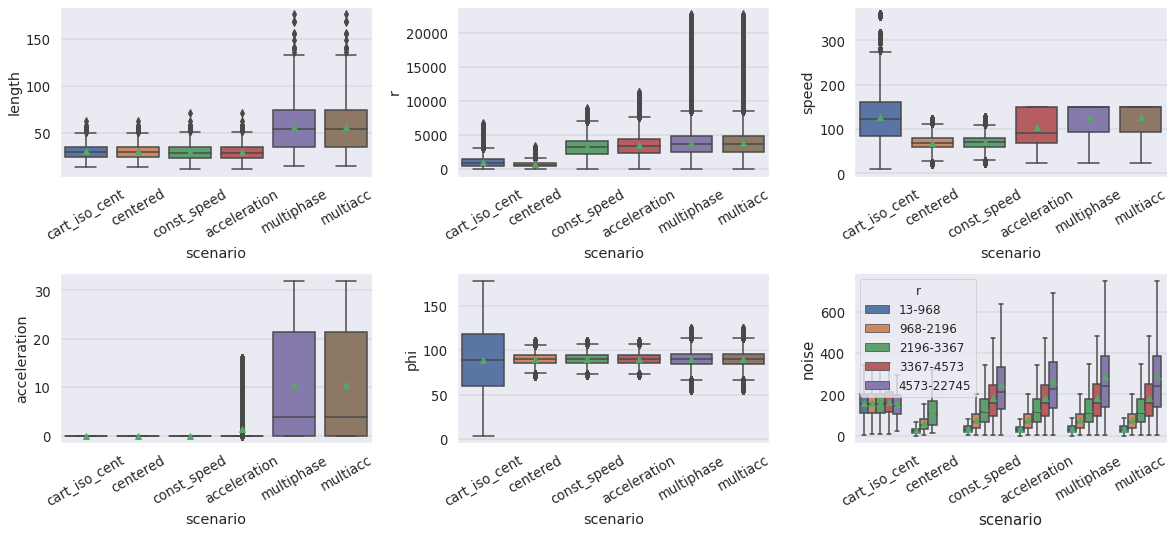

In [8]:
%time axs, dd, dd_tar = ssim.summarize_scenarios(list(scenarios_args.keys()))

# Train & test

For each scenario: for each model: train the model on the scenario's train data, then test it on the test data of the same scenario.


cart_iso_cent
Waiting for trainings...
Waiting for processes...
Done.	(202 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 88 (OKF_s00)
	KF_pol: inf (KF_pol_s00)
	OKF_pol: 129 (OKF_pol_s00)
	EKF: inf (EKF_s00)
	OEKF: 84 (OEKF_s00)
	EKF_pol: inf (EKF_pol_s00)
	OEKF_pol: 115 (OEKF_pol_s00)
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(26 [s])

centered
Waiting for trainings...
Waiting for processes...
Done.	(204 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 27 (OKF_s00)
	KF_pol: inf (KF_pol_s00)
	OKF_pol: 25 (OKF_pol_s00)
	EKF: inf (EKF_s00)
	OEKF: 28 (OEKF_s00)
	EKF_pol: inf (EKF_pol_s00)
	OEKF_pol: 27 (OEKF_pol_s00)
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(26 [s])

const_speed
Waiting for trainings...
Waiting for processes...
Done.	(202 [s])
Best validation losses:
	KF: inf (KF_s00)
	OKF: 95 (OKF_s00)
	KF_pol: inf (KF_pol_s00)
	OKF_pol: 94 (OKF_pol_s00)
	EKF: inf (EKF_s00)
	OEKF: 105 (OEKF_s00)


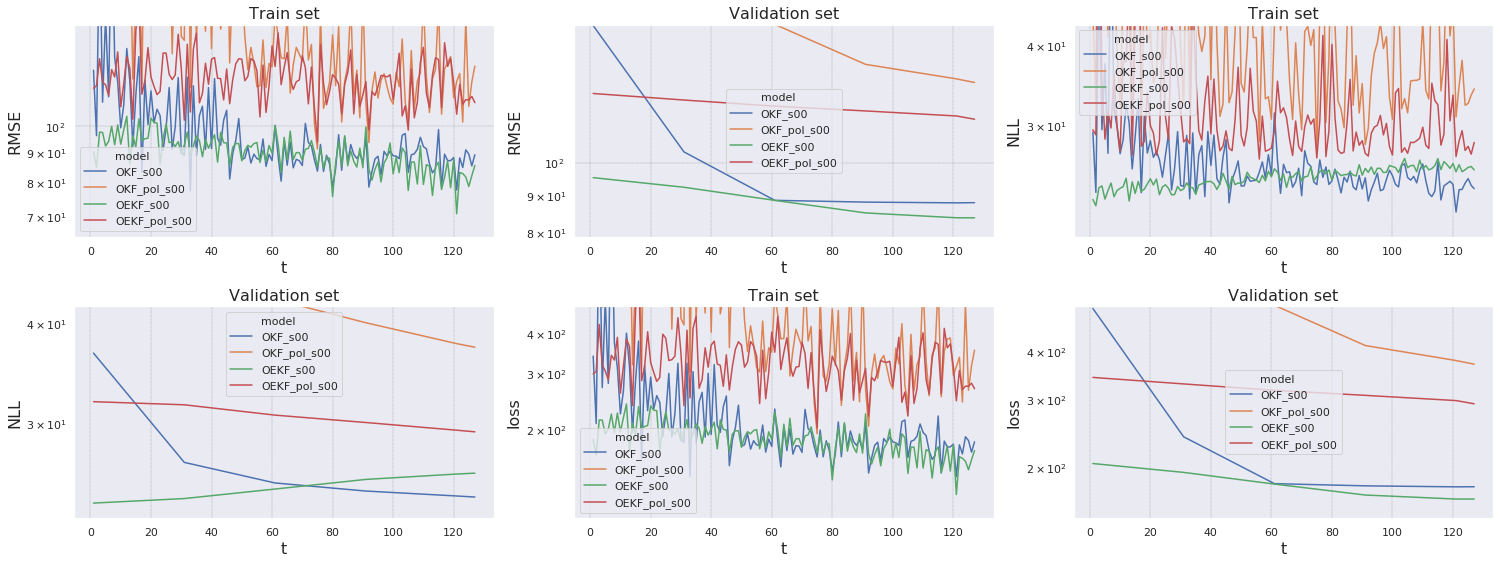

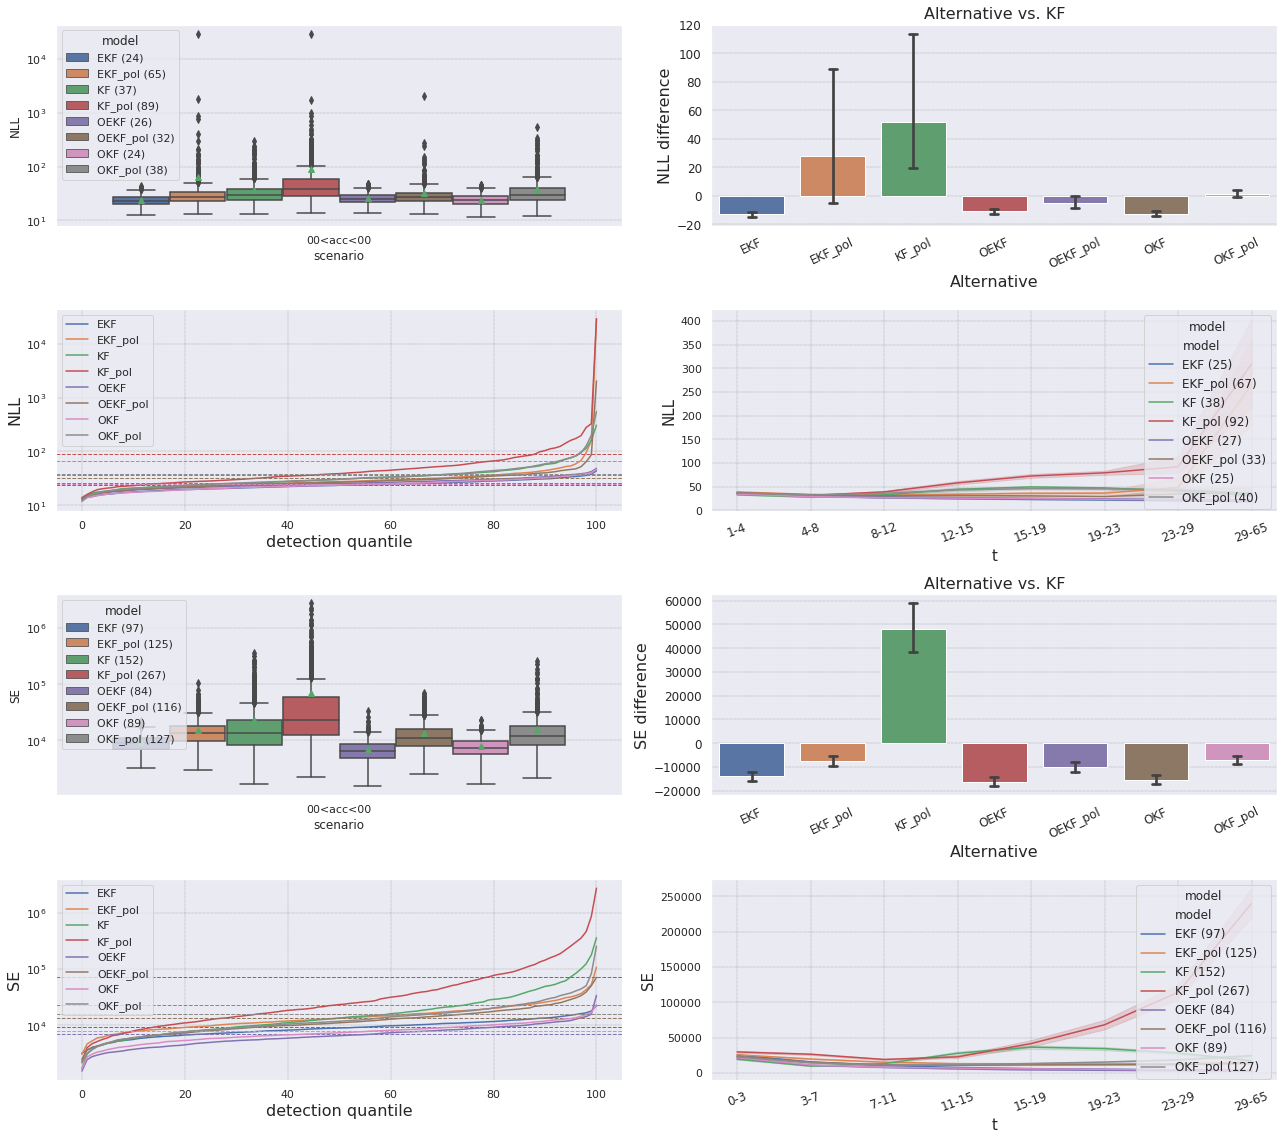

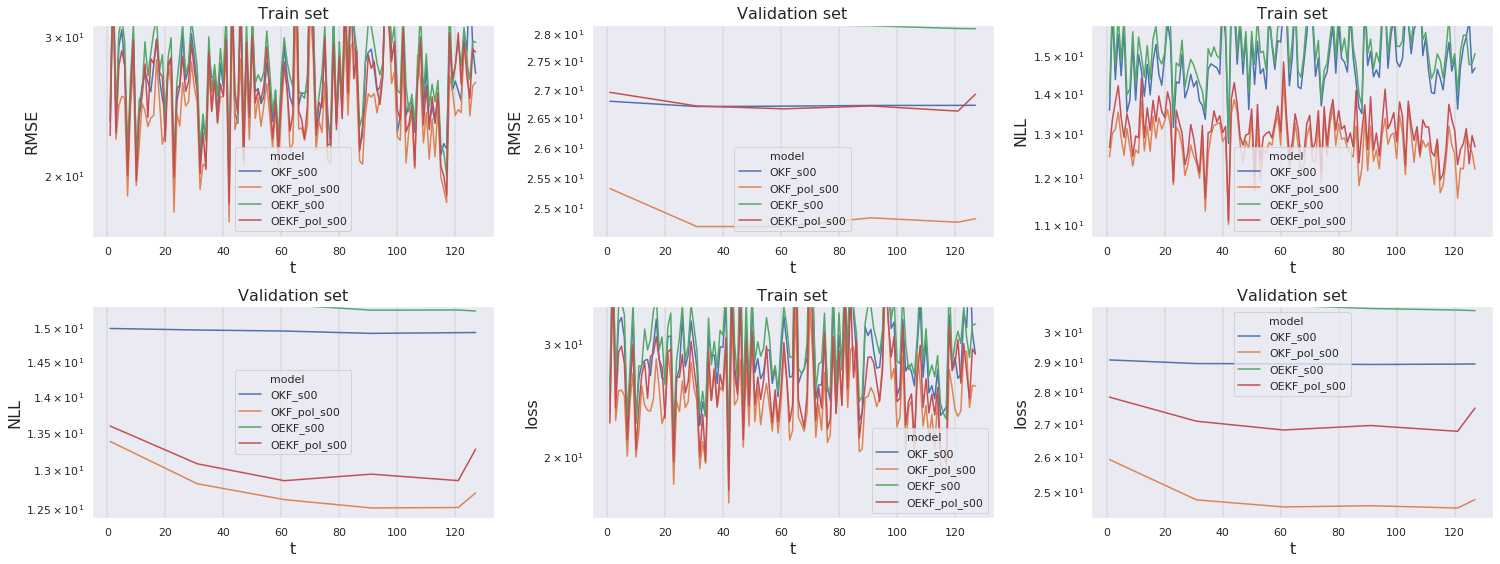

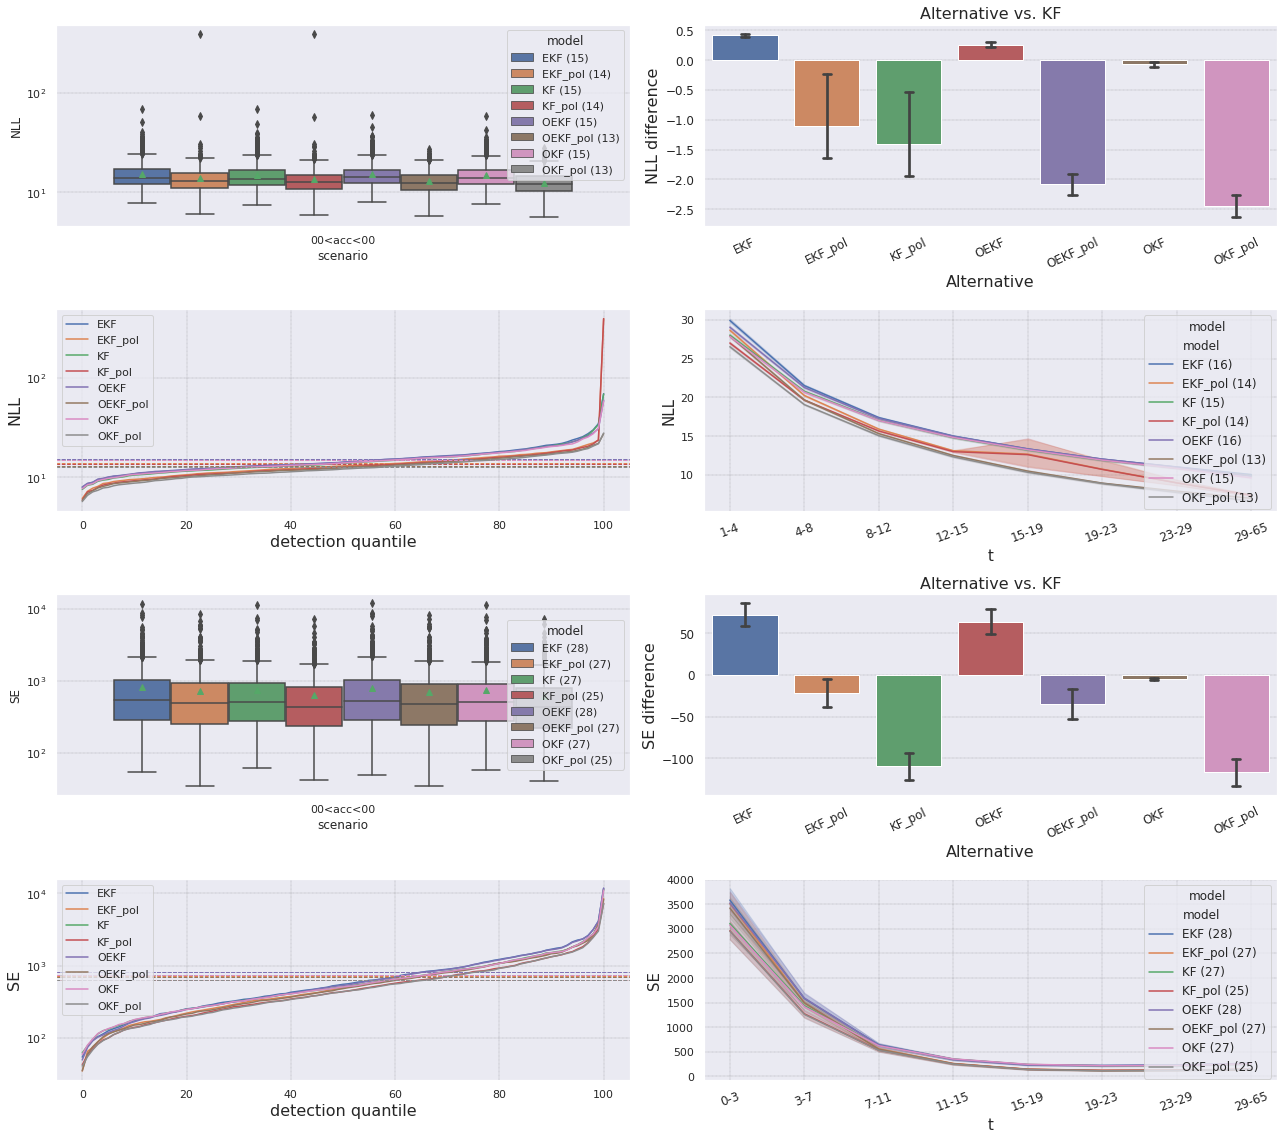

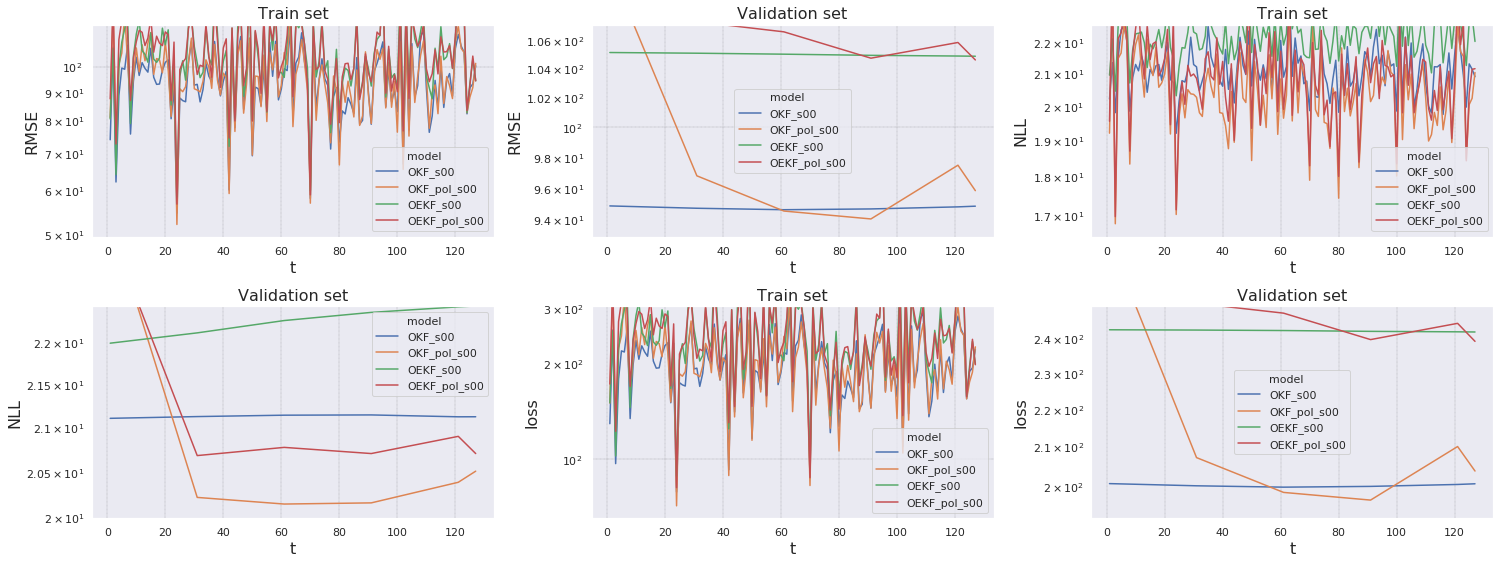

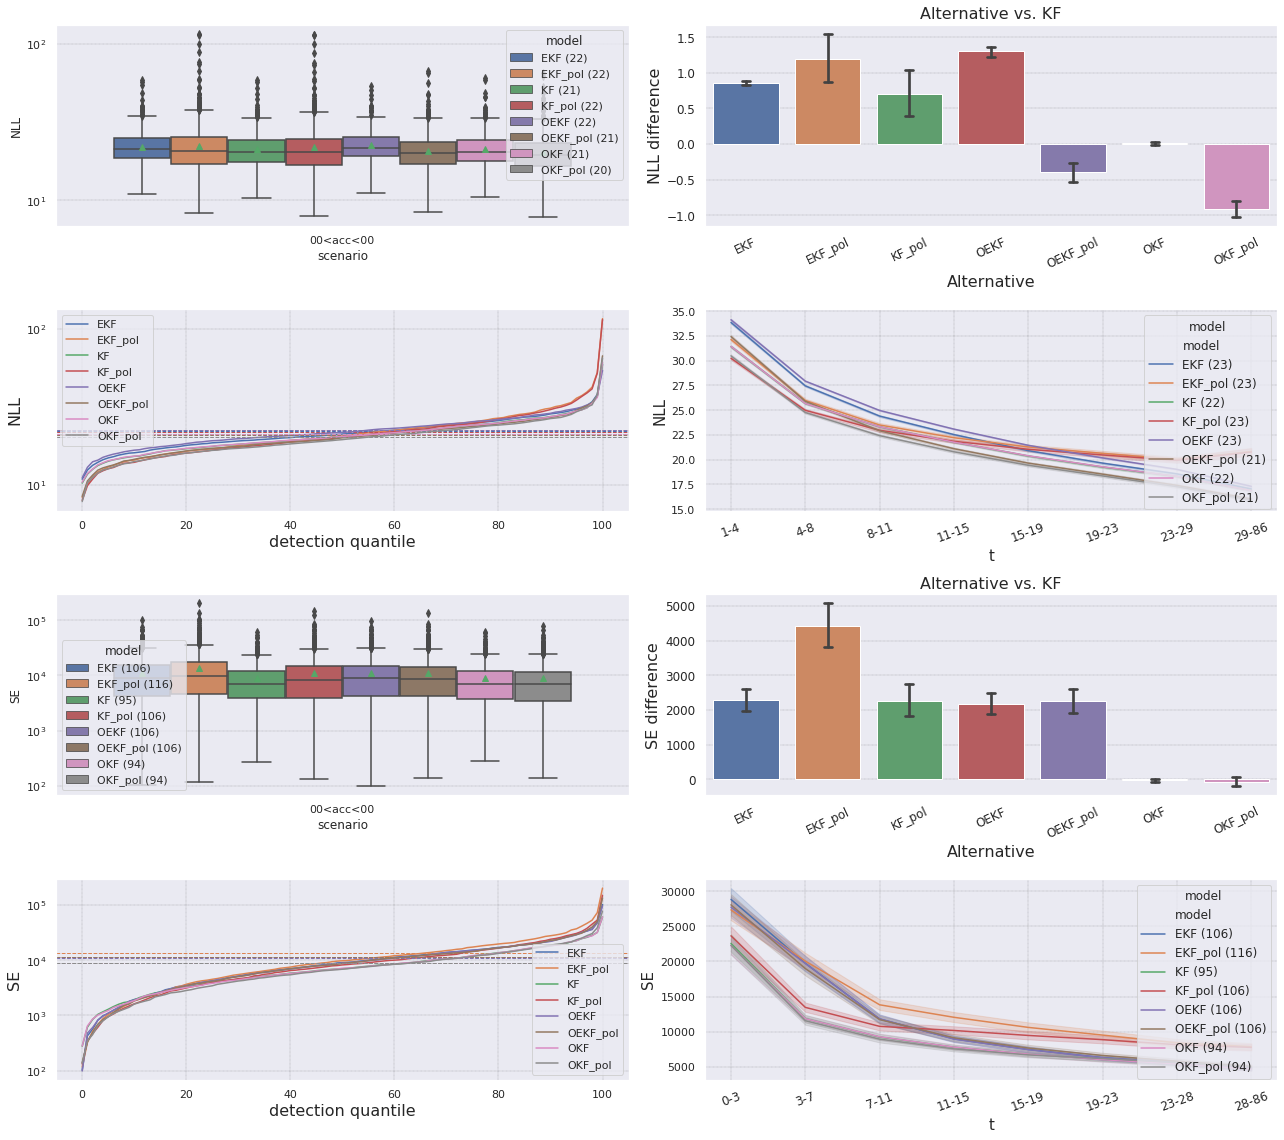

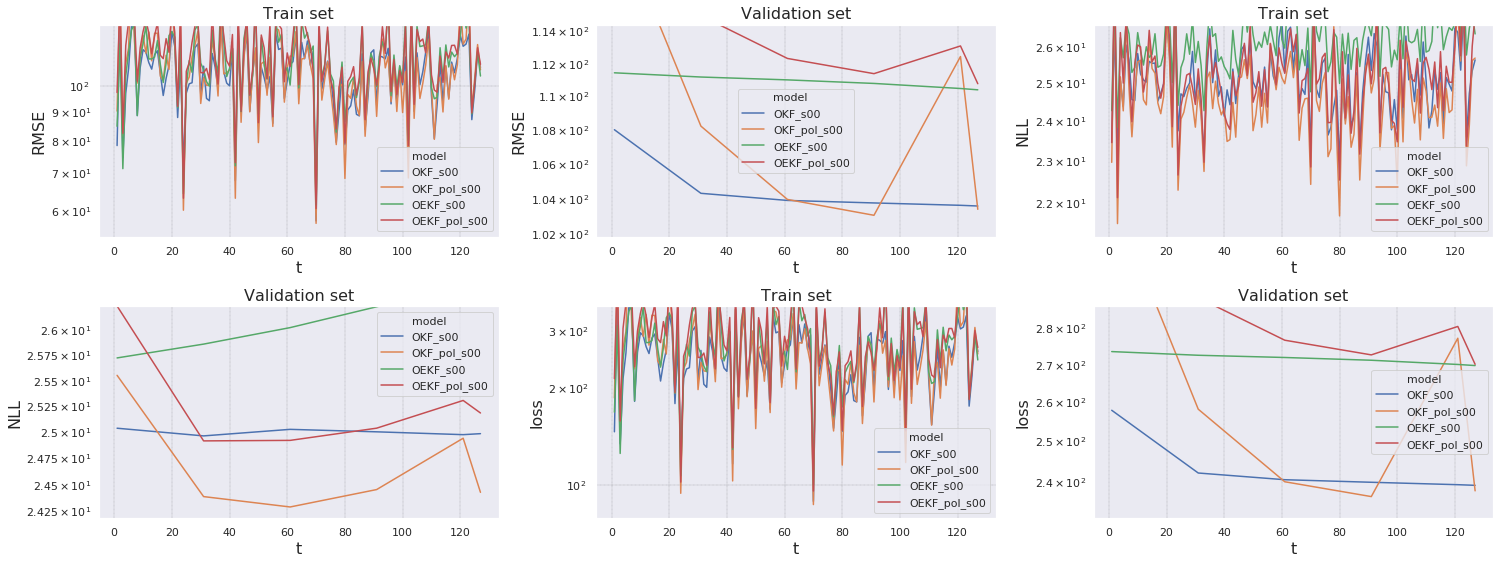

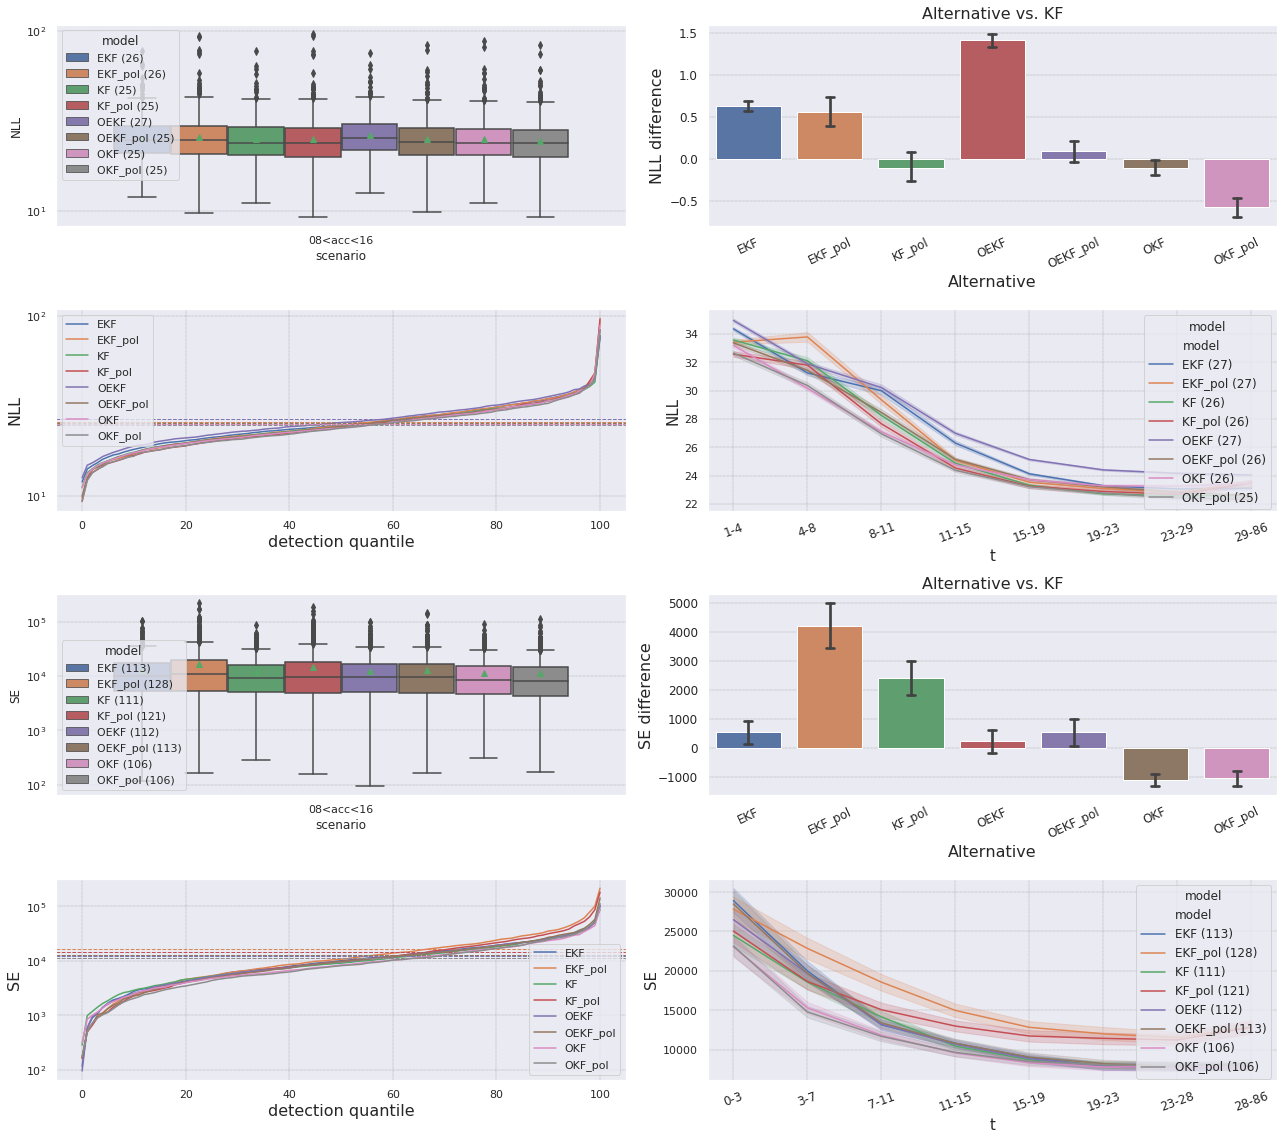

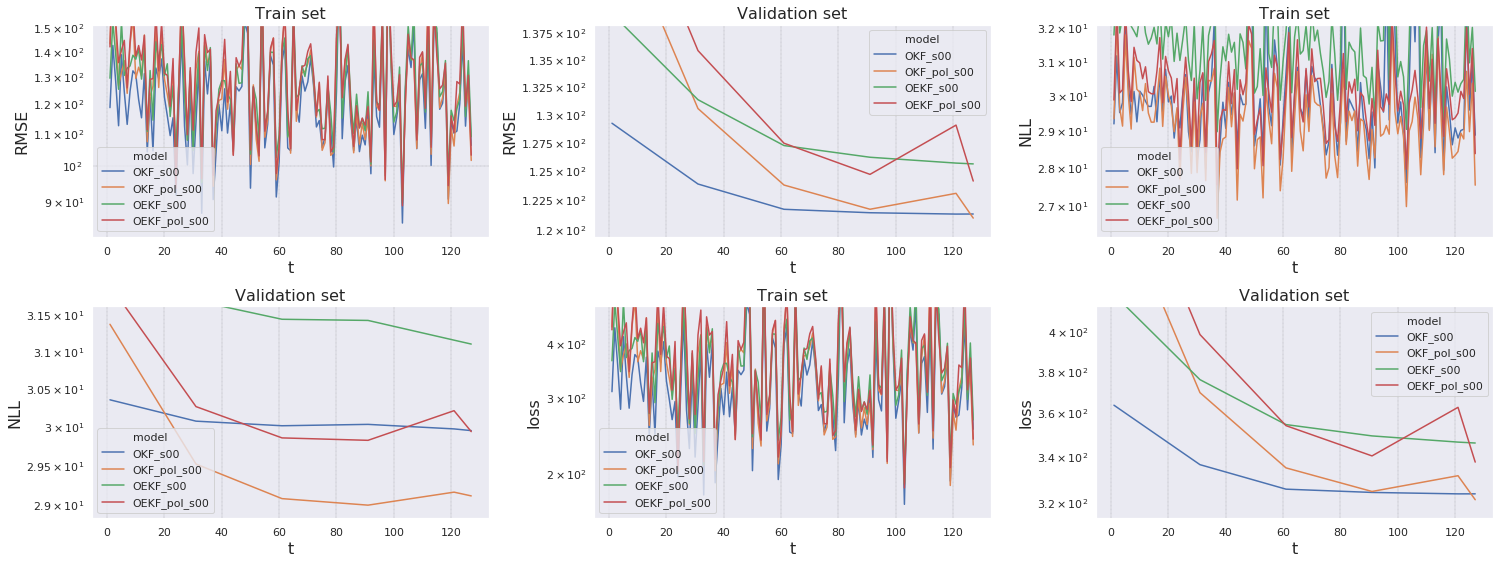

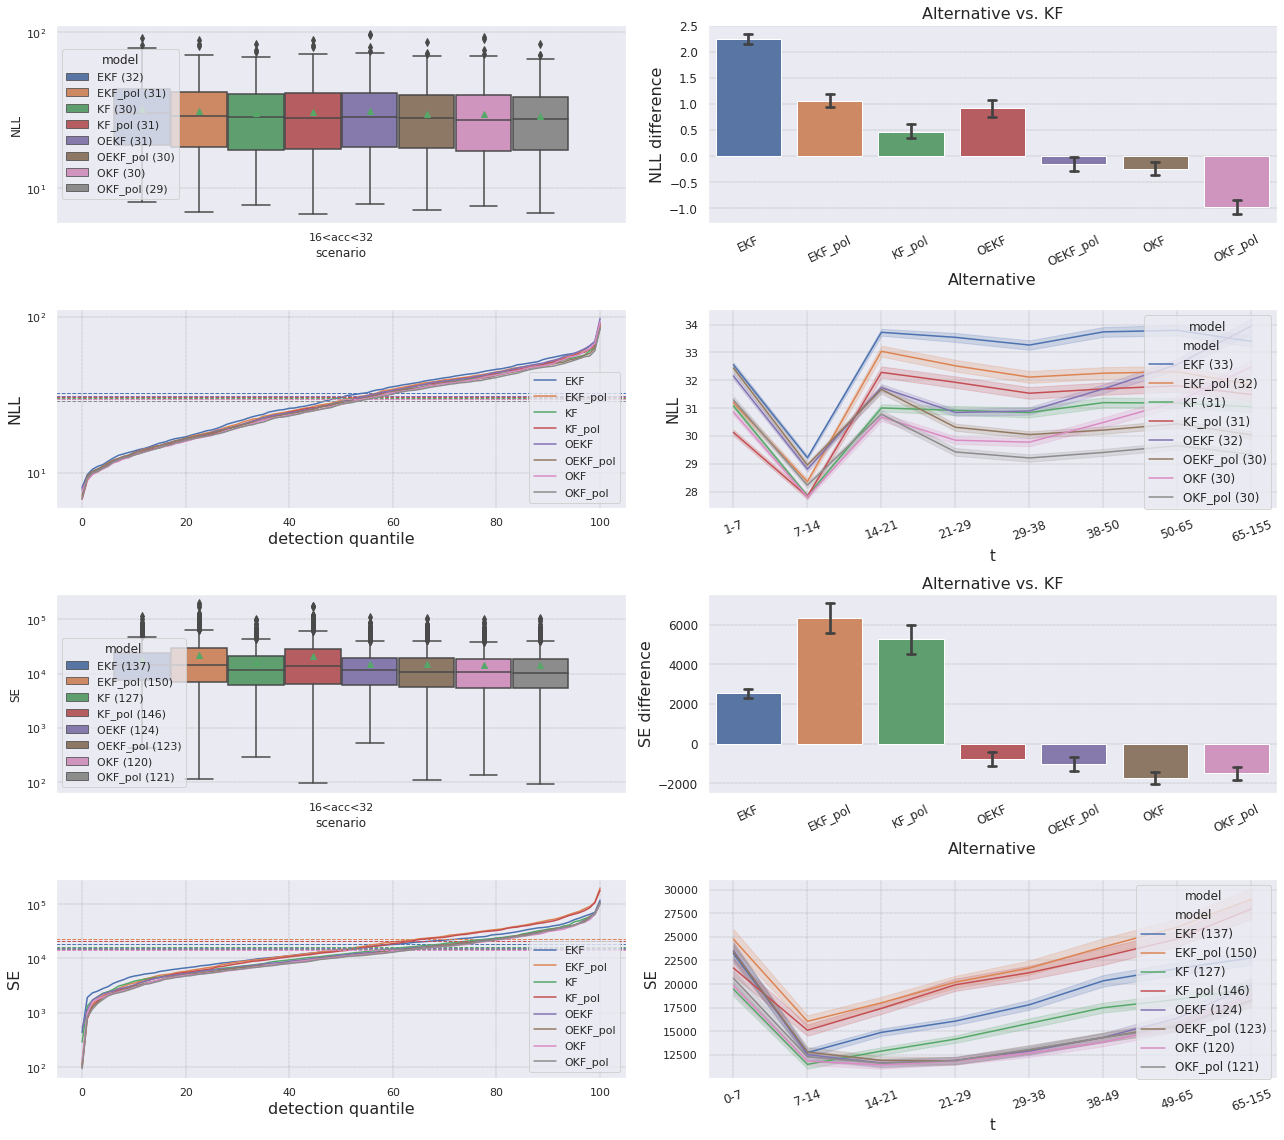

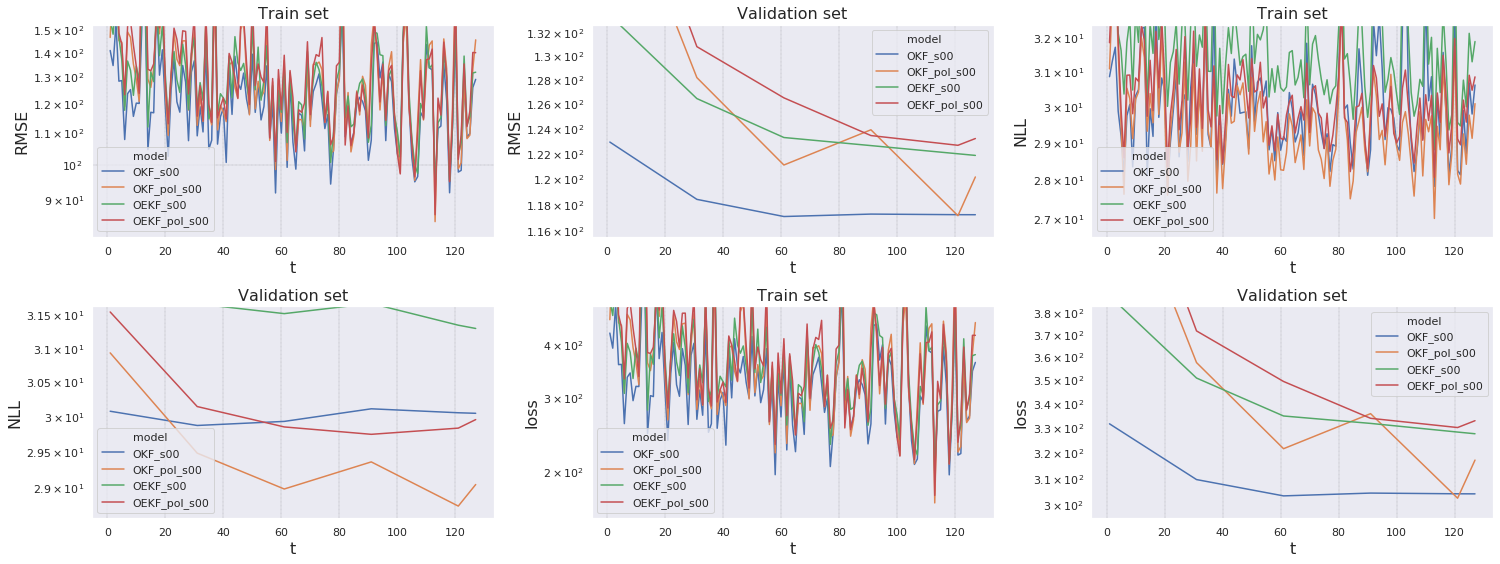

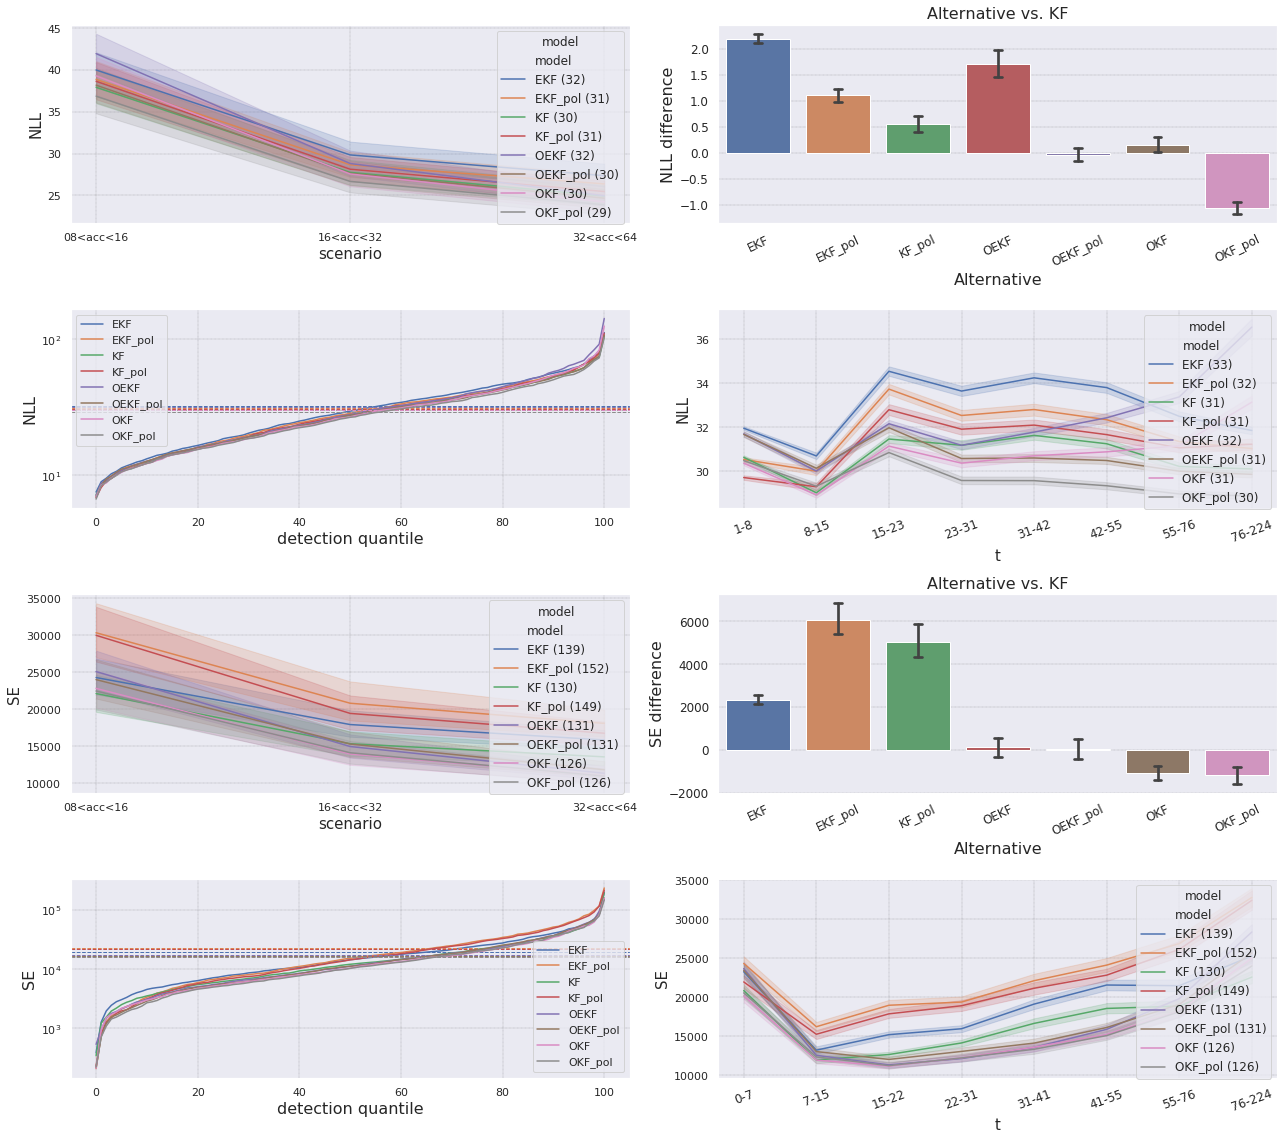

In [10]:
scenarios = list(scenarios_args.keys())
res = PLAB.multi_scenario_test(scenarios, models_args)

In [12]:
res

model       scenario  target   t  predicted_gaussian  \
0             KF  cart_iso_cent       0   0                   0   
1             KF  cart_iso_cent       0   1                   0   
2             KF  cart_iso_cent       0   2                   0   
3             KF  cart_iso_cent       0   3                   0   
4             KF  cart_iso_cent       0   4                   0   
...          ...            ...     ...  ..                 ...   
477883  OEKF_pol       multiacc     990  70                   0   
477884  OEKF_pol       multiacc     990  71                   0   
477885  OEKF_pol       multiacc     990  72                   0   
477886  OEKF_pol       multiacc     990  73                   0   
477887  OEKF_pol       multiacc     990  74                   0   

        matched_gaussian        NLL            SE          AE        loss  \
0                      0   0.000000   3304.538466   57.485115   66.090769   
1                      0  35.673796   4592.003723   67.764325  126.800395   
2                      0  30.141762  18698.214642  136.741415  403.503220   
3                      0  29.399480   7499.555773   86.599976  178.802606   
4                      0  27.879694   1467.229642   38.304434   56.666693   
...                  ...        ...           ...         ...         ...   
477883                 0  25.099761   5081.232237   71.282763  126.222411   
477884                 0  25.789568    812.974630   28.512710   41.533269   
477885                 0  22.969626   2099.272458   45.817818   64.495682   
477886                 0  25.907232   1810.586633   42.550989   61.600820   
477887                 0  24.222804     86.128523    9.280545   25.460919   

        tar_class  
0       00<acc<00  
1       00<acc<00  
2       00<acc<00  
3       00<acc<00  
4       00<acc<00  
...           ...  
477883  32<acc<64  
477884  32<acc<64  
477885  32<acc<64  
477886  32<acc<64  
477887  32<acc<64  

[1891232 rows x 11 columns]

Aggregate results per target:

In [13]:
res_tar = PLAB.res_per_target(res, ['model','scenario'])
res_tar

scenario  target    model  wt        NLL  \
target model   scenario                                                         
0      EKF     acceleration  0   acceleration       0      EKF  34  23.250820   
               cart_iso_cent 0  cart_iso_cent       0      EKF  33  19.424488   
               centered      0       centered       0      EKF  33  10.873330   
               const_speed   0    const_speed       0      EKF  34  16.404034   
               multiacc      0       multiacc       0      EKF  49  45.955673   
...                                       ...     ...      ...  ..        ...   
990    OKF_pol cart_iso_cent 0  cart_iso_cent     990  OKF_pol  52  92.972035   
               centered      0       centered     990  OKF_pol  52  12.373284   
               const_speed   0    const_speed     990  OKF_pol  22  11.754235   
               multiacc      0       multiacc     990  OKF_pol  75  59.644157   
               multiphase    0     multiphase     990  OKF_pol  44  36.021229   

                                          SE          AE        loss  \
target model   scenario                                                
0      EKF     acceleration  0   2981.754699   47.781533   96.380315   
               cart_iso_cent 0   7520.305000   69.232410  204.144319   
               centered      0    310.171542   12.519526   20.312125   
               const_speed   0    714.894739   18.723843   35.518189   
               multiacc      0  14245.699301  109.749849  267.721153   
...                                      ...         ...         ...   
990    OKF_pol cart_iso_cent 0  55041.290002  236.517176  911.339893   
               centered      0    891.717740   20.372684   22.907141   
               const_speed   0   7996.614371   57.911469  309.847763   
               multiacc      0  16777.081388  140.281448  208.860854   
               multiphase    0  10757.660918   99.266736  226.310785   

                                tar_class  
target model   scenario                    
0      EKF     acceleration  0  08<acc<16  
               cart_iso_cent 0  00<acc<00  
               centered      0  00<acc<00  
               const_speed   0  00<acc<00  
               multiacc      0  32<acc<64  
...                                   ...  
990    OKF_pol cart_iso_cent 0  00<acc<00  
               centered      0  00<acc<00  
               const_speed   0  00<acc<00  
               multiacc      0  32<acc<64  
               multiphase    0  16<acc<32  

[47568 rows x 9 columns]

# Results analysis

#### Summary of results:

Estimated KFs:

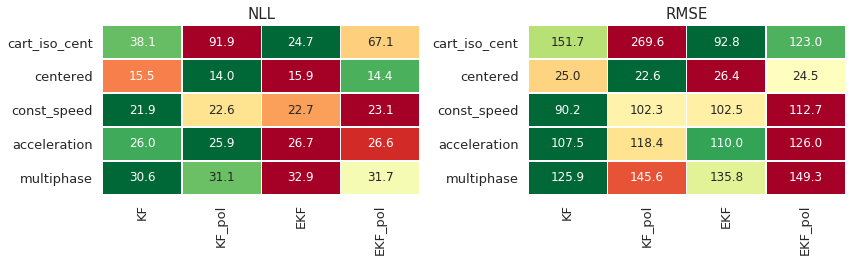

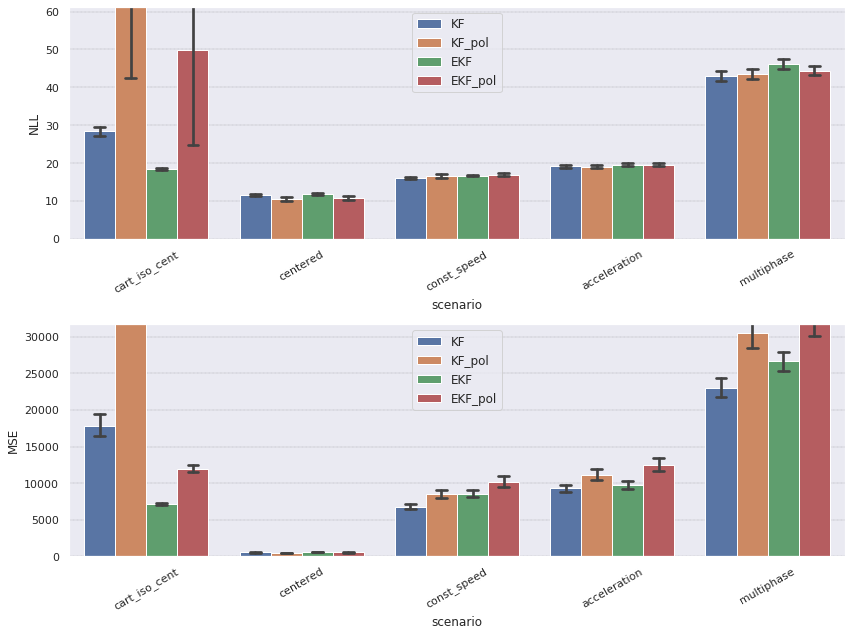

In [21]:
axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios[:-1], models=('KF','KF_pol','EKF','EKF_pol'));

Optimized KFs:

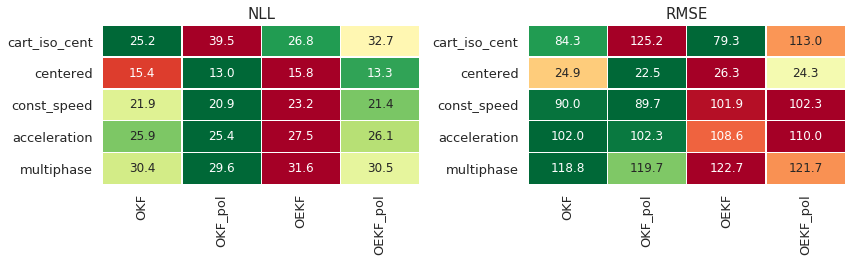

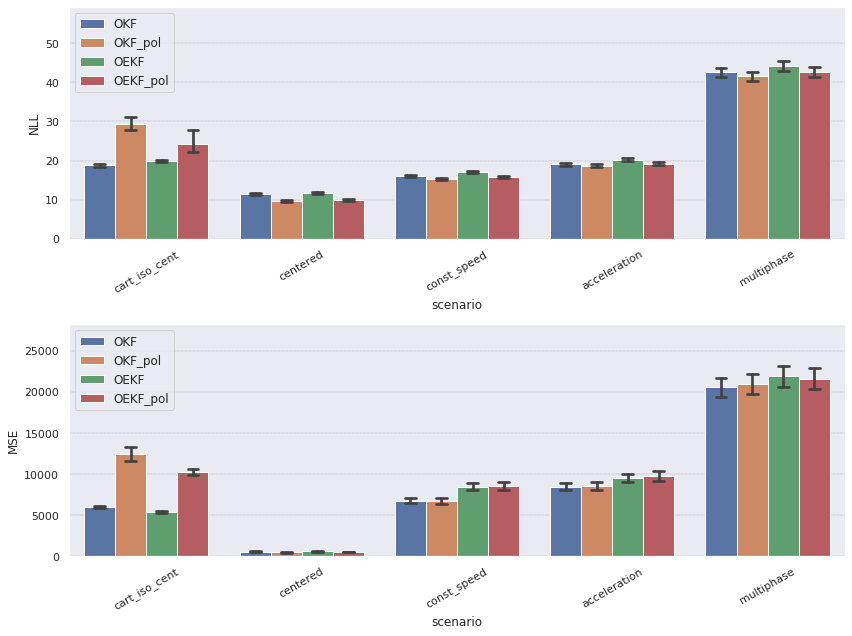

In [20]:
axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios[:-1], models=('OKF','OKF_pol','OEKF','OEKF_pol'));

All KFs:

CPU times: user 13 s, sys: 47.5 ms, total: 13 s
Wall time: 13 s


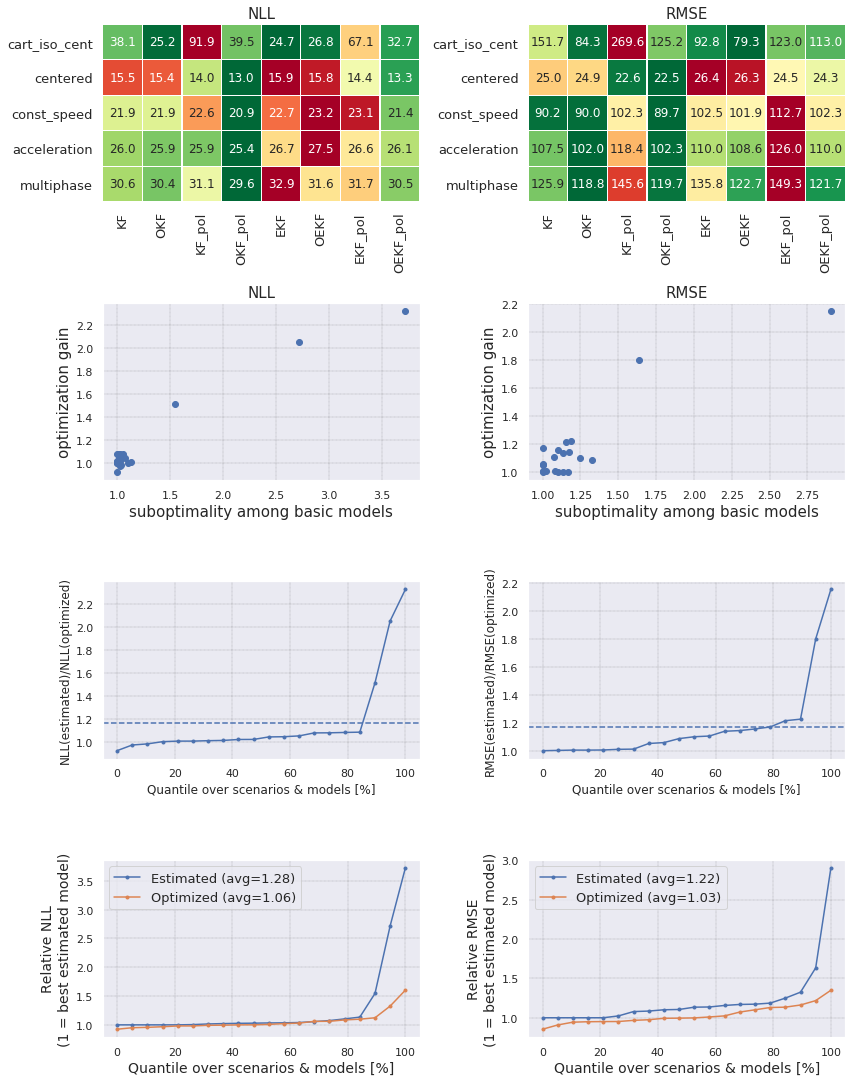

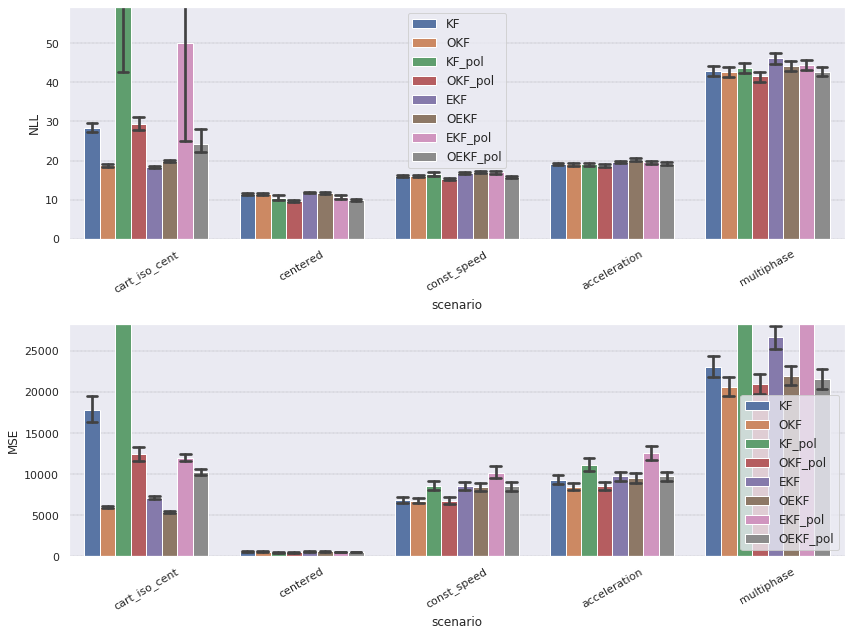

In [18]:
%time axs = PLAB.multi_scenario_analysis(res, res_tar, scenarios=scenarios[:-1], models=('KF','OKF','KF_pol','OKF_pol','EKF','OEKF','EKF_pol','OEKF_pol'));

#### KF vs. OKF on a sample of targets

XY plane:

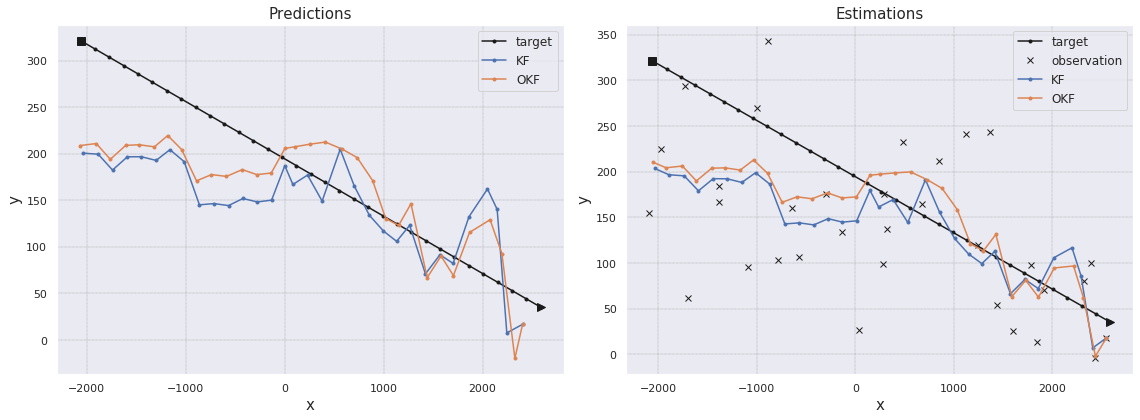

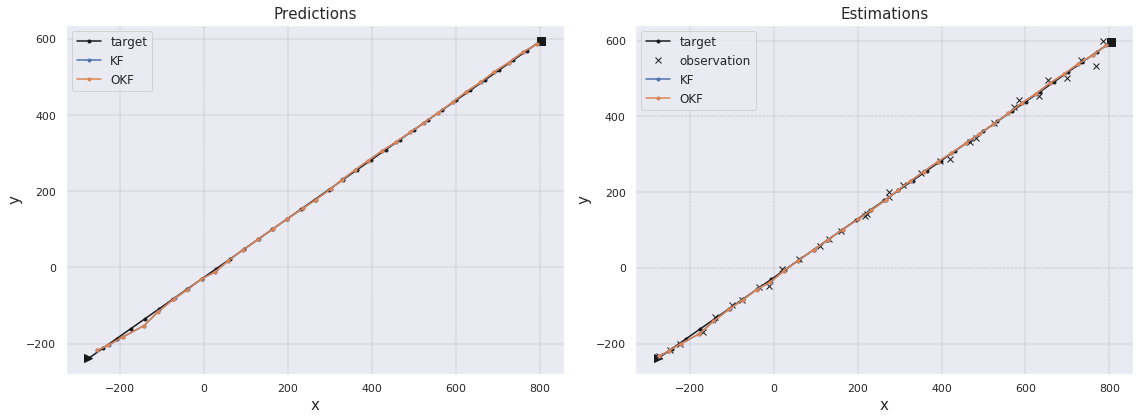

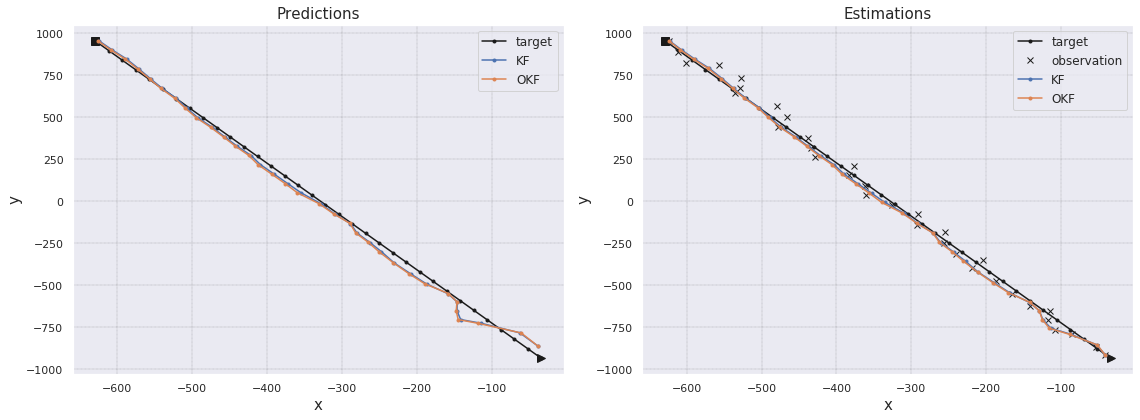

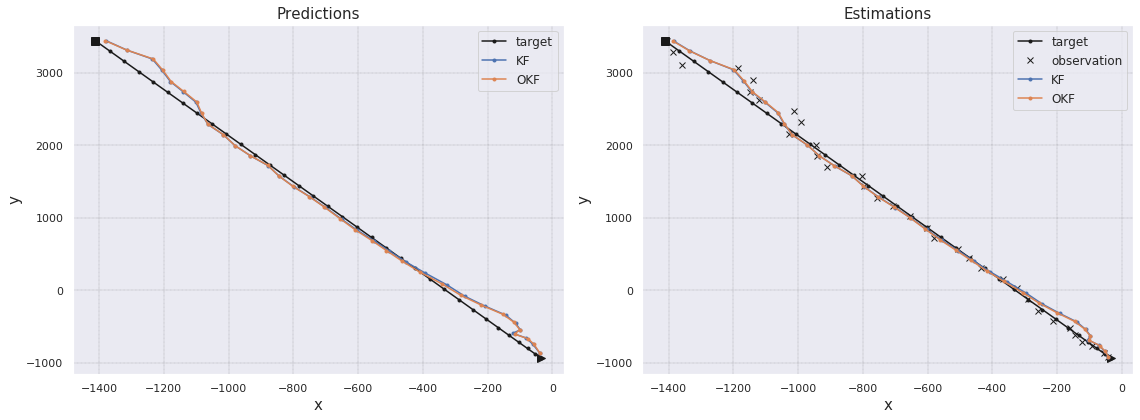

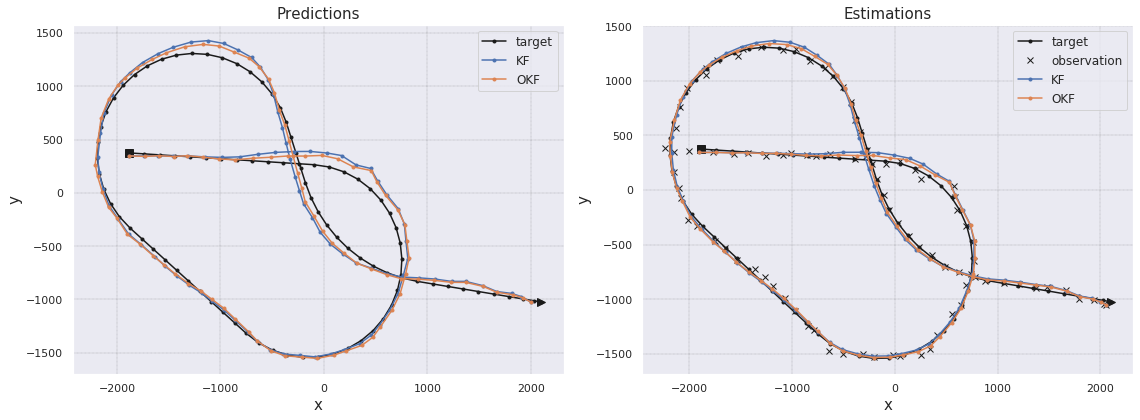

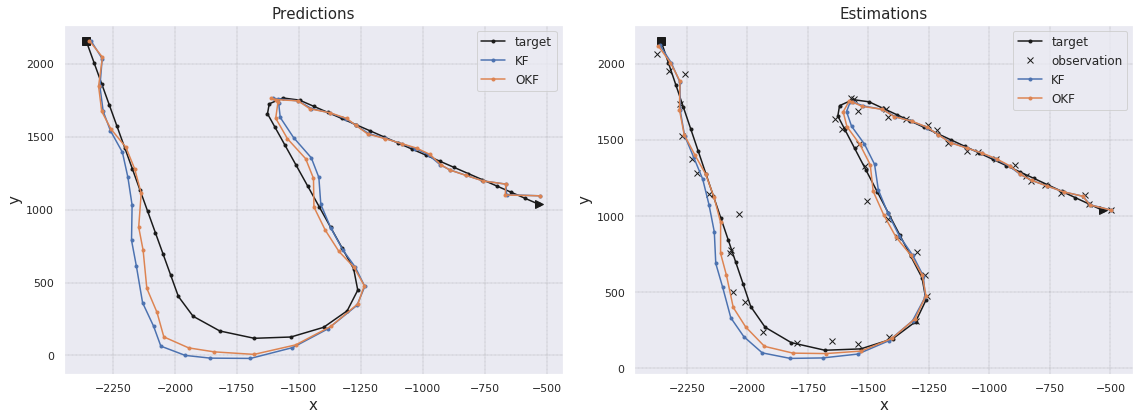

In [22]:
margs = [m for m in models_args if m['title'] in ('KF','OKF')]
axs = PLAB.multi_scenario_models_plot(scenarios, margs, 0);
# axs[-1][0].set_xlim((-2000,-1500))
# axs[-1][1].set_xlim((-2000,-1500))
# axs[-1][0].set_ylim((-2400,-1800))
# axs[-1][1].set_ylim((-2400,-1800))

XZ plane:

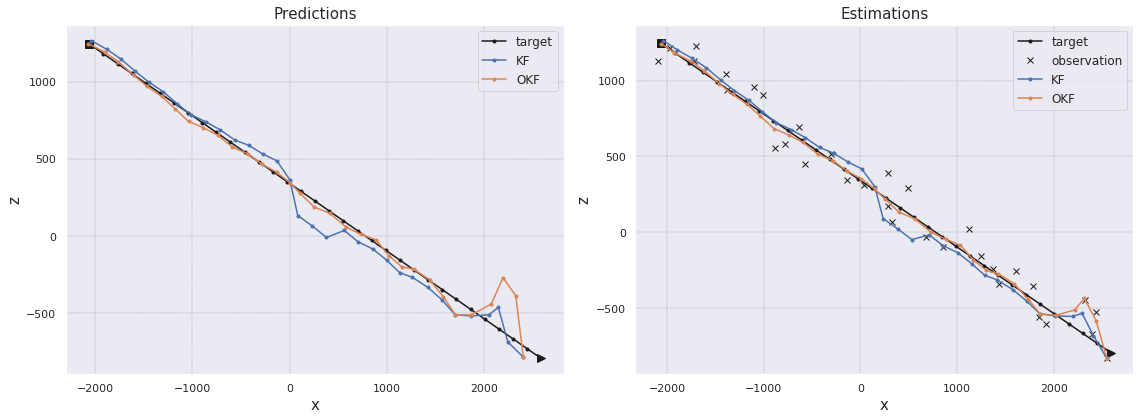

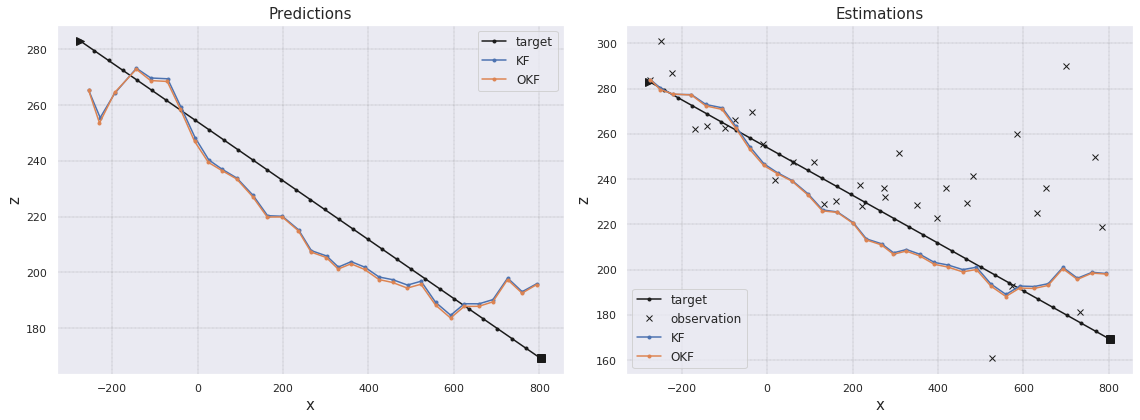

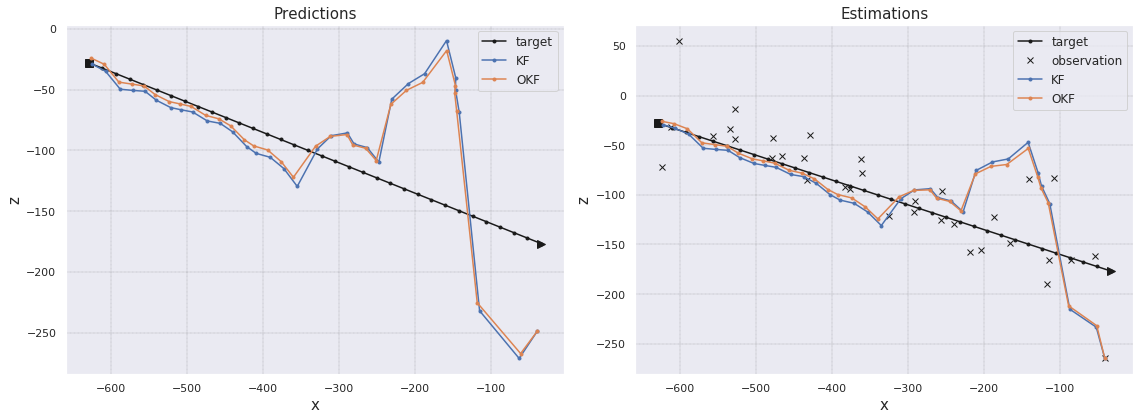

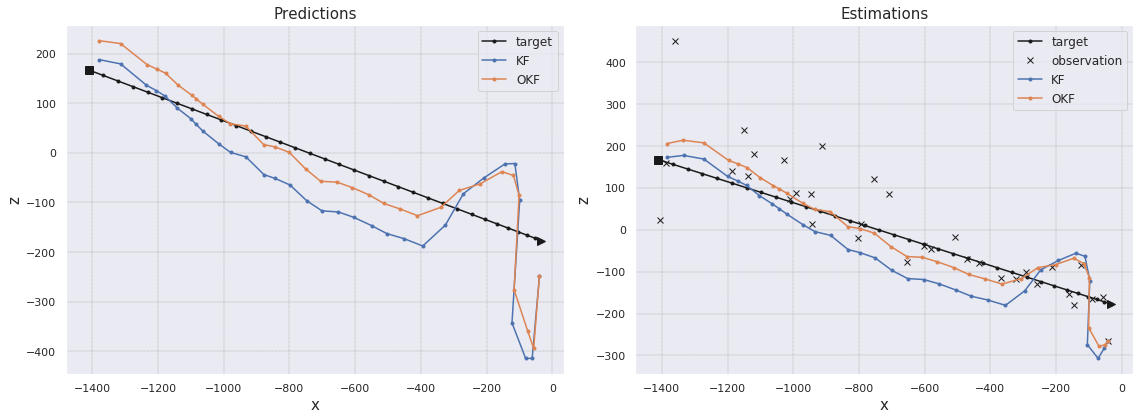

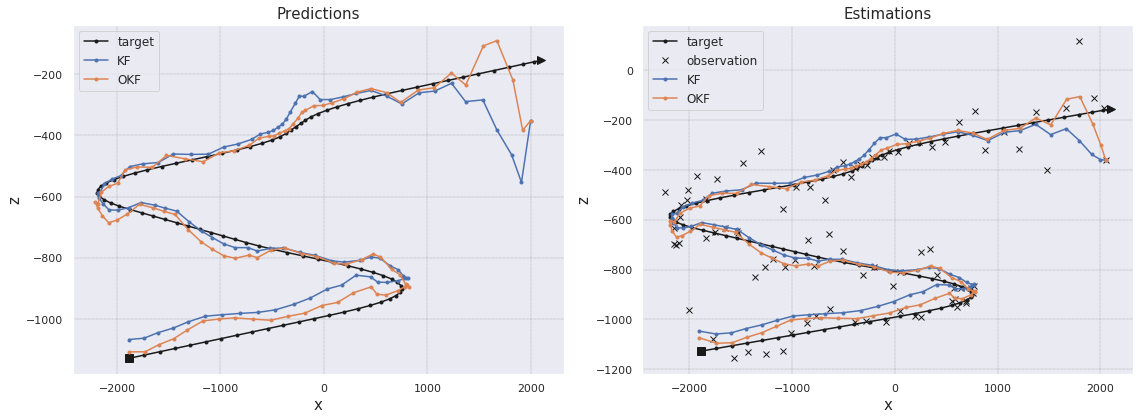

In [127]:
axs = PLAB.multi_scenario_models_plot(scenarios, margs, 0, dimy=2);

#### R & Q in KF vs. OKF

In R, OKF assigns less credit to the doppler signal (the variance of x,y,z is smaller).
Q is quite similar (OKF assigns slightly more credit to position over speed).

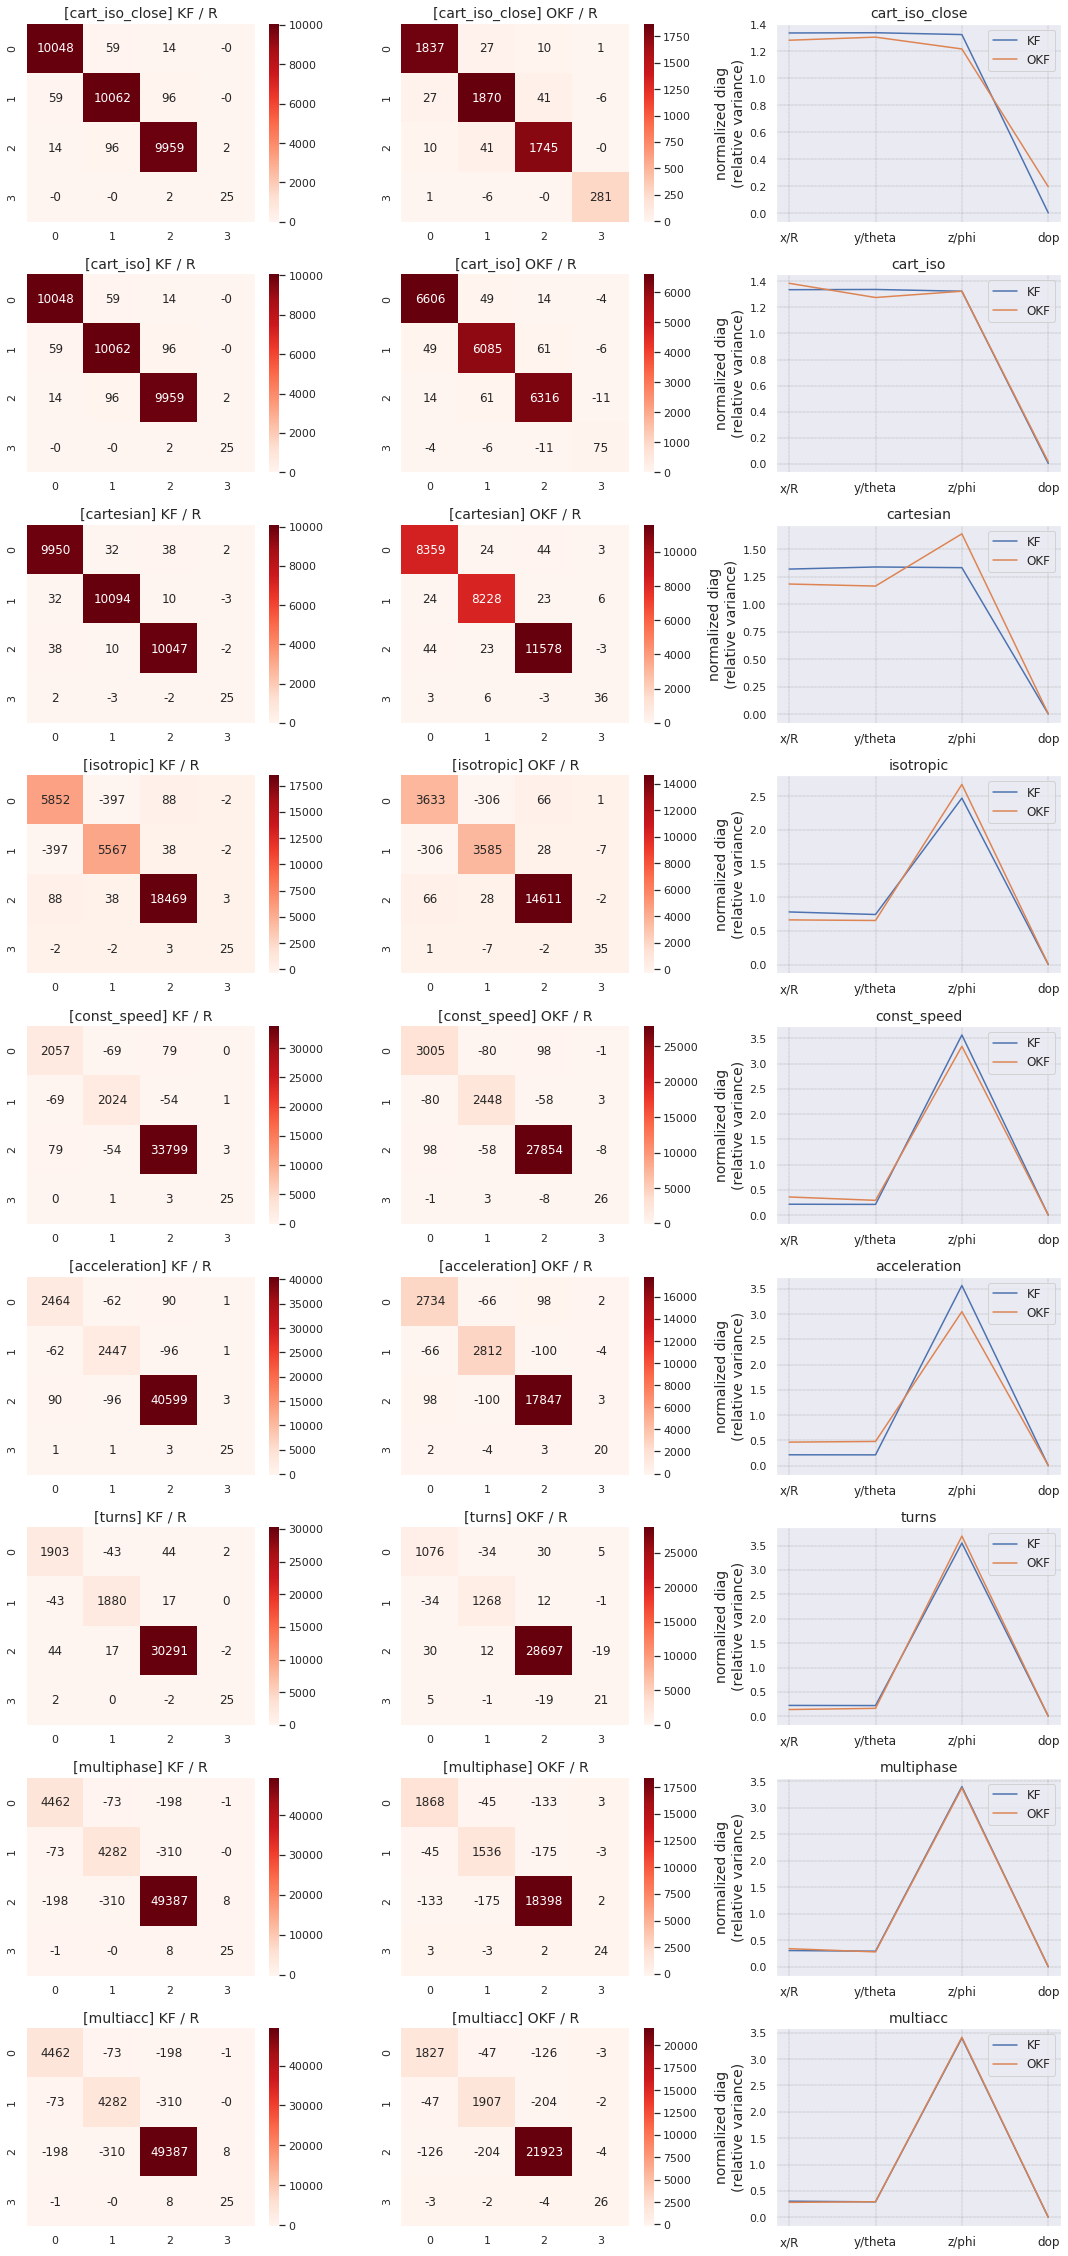

In [32]:
PLAB.compare_noise_models(scenarios, margs, noise='R');

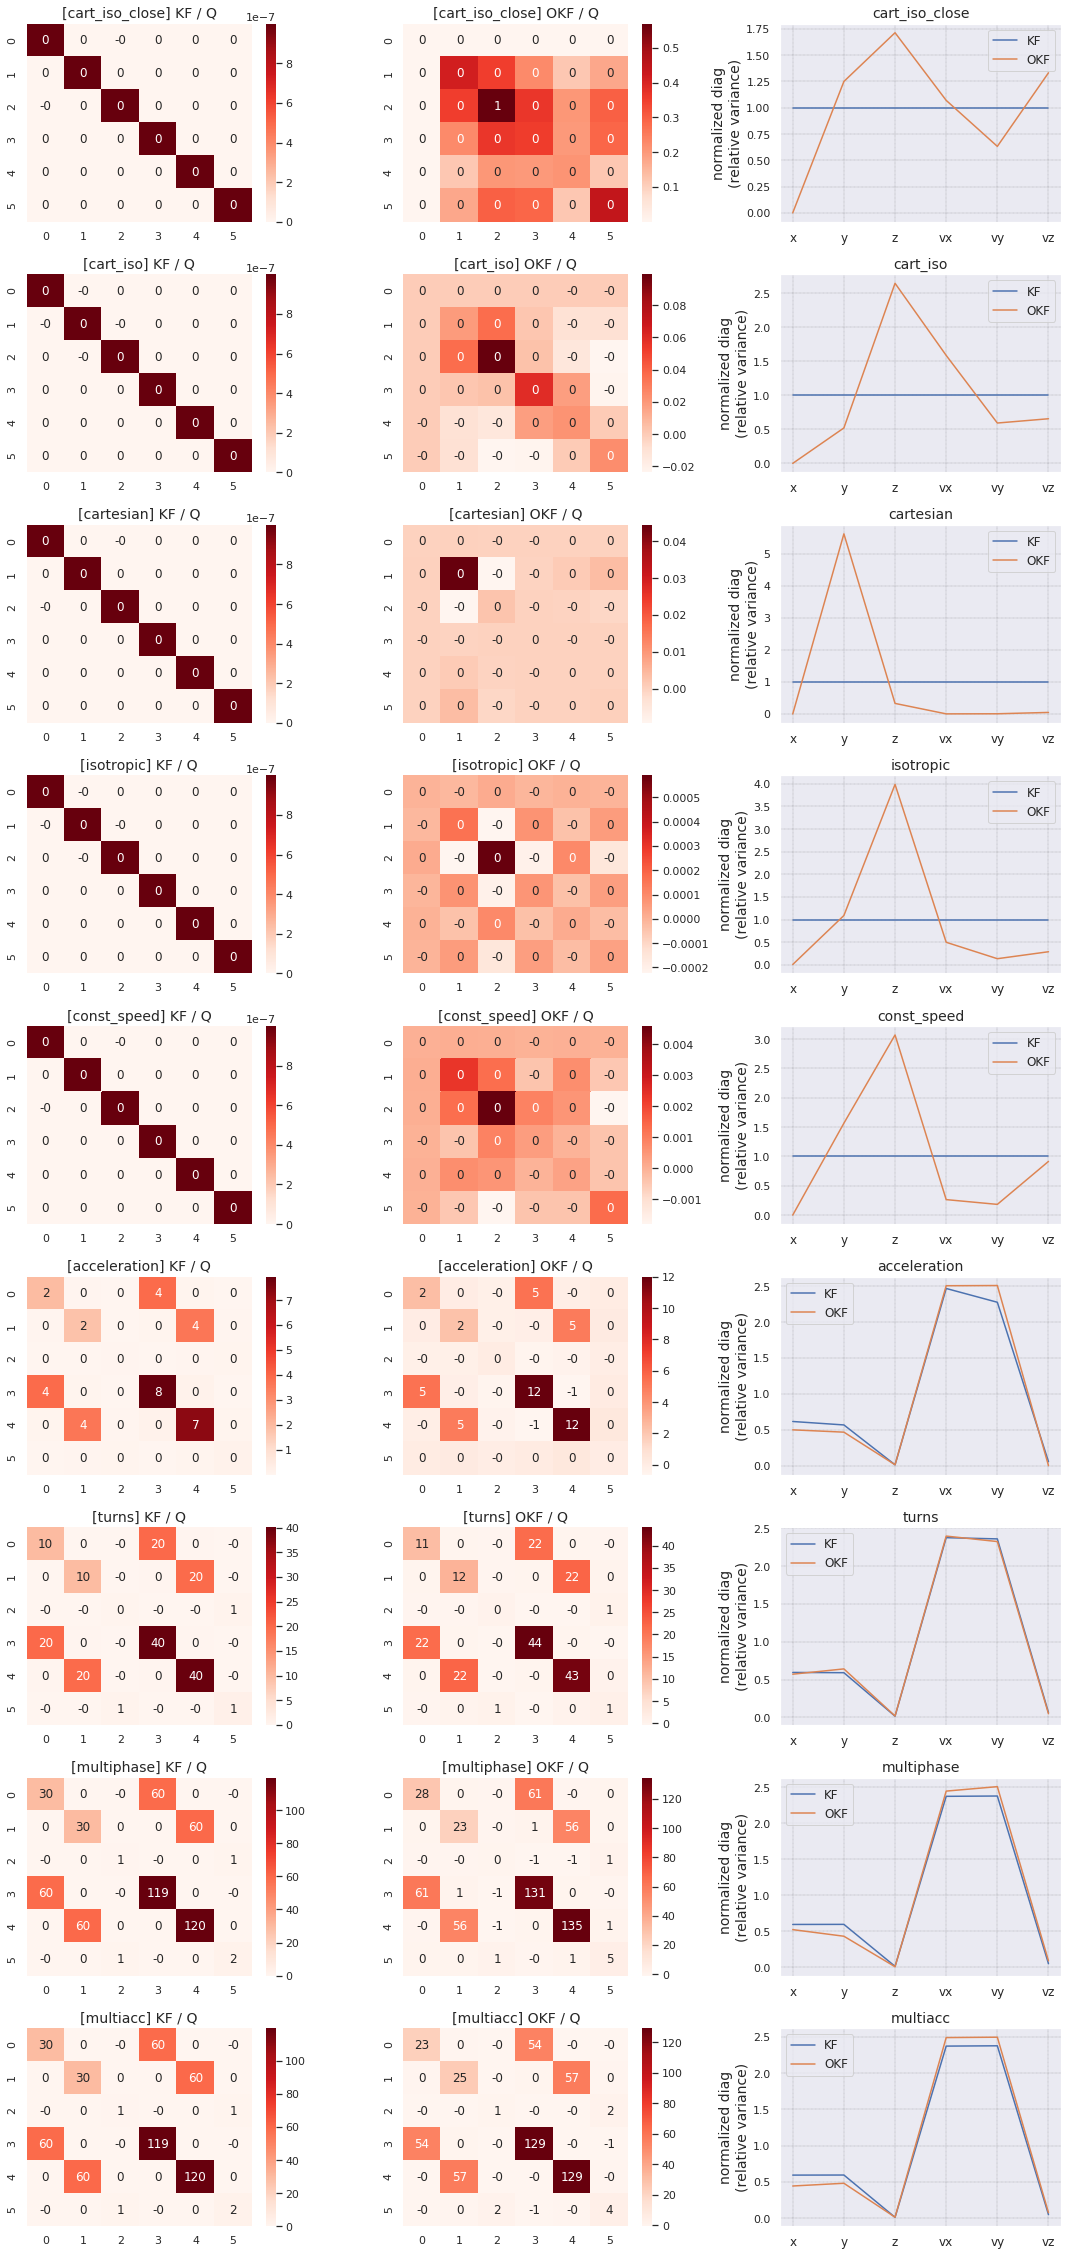

In [33]:
PLAB.compare_noise_models(scenarios, margs, noise='Q', log=False)

## Generalization wrt target acceleration

Generalization to different ranges of acceleration:

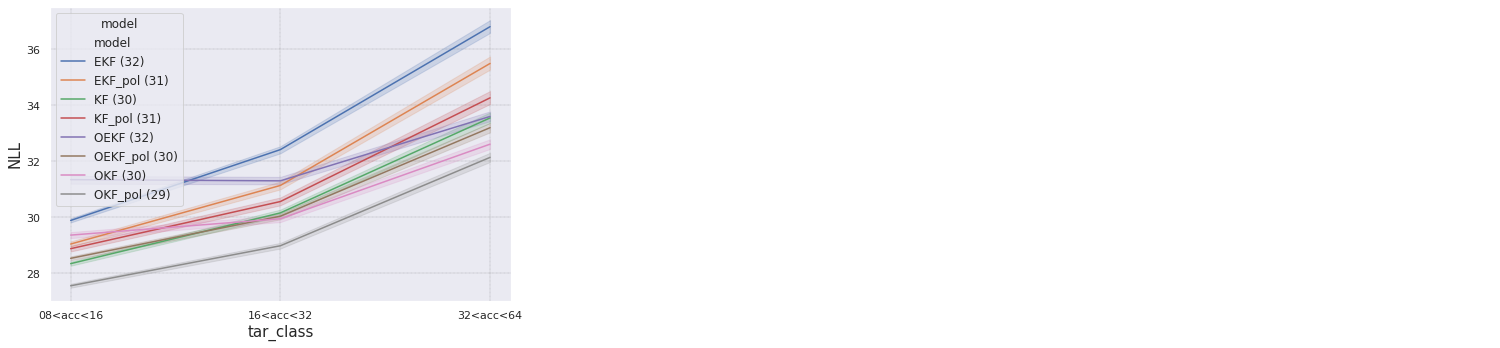

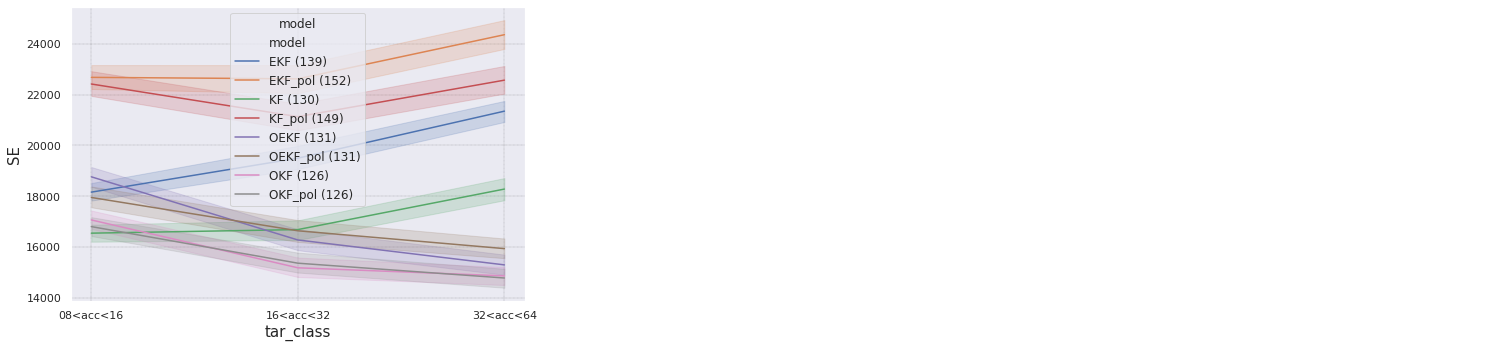

In [15]:
utils.compare_quantiles(res[res.scenario=='multiacc'], x='tar_class', y='NLL', hue='model');
utils.compare_quantiles(res[res.scenario=='multiacc'], x='tar_class', y='SE', hue='model', mean=lambda x:np.sqrt(np.mean(x)));

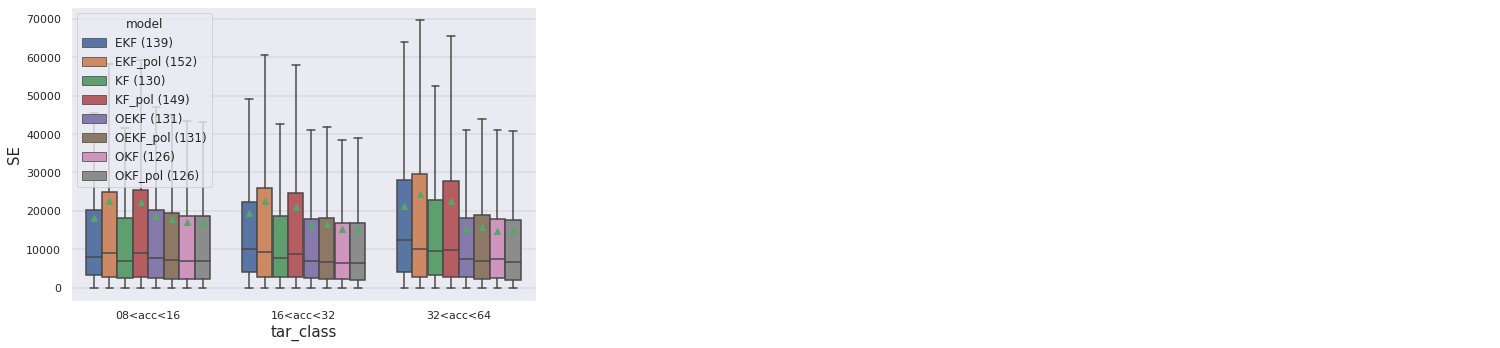

In [16]:
utils.compare_quantiles(res[res.scenario=='multiacc'], x='tar_class', y='SE', hue='model', box=True, showfliers=False,
                        order=('08<acc<16','16<acc<32','32<acc<64'), mean=lambda x:np.sqrt(np.mean(x)));

## Generalization across scenarios

For each pair `(i,j)` of scenarios: train on i's train data and test on j's test data.

The scenarios are roughly sorted by complexity, thus $i<j$ corresponds to "positive" generalization direction (generalizing to more complex scenario), and $i>j$ to "negative" direction (generalizing to simpler scenario).

In [23]:
%time gres, MSE, NLL = PLAB.test_across_scenarios(scenarios, models_args)

Running models trained on cart_iso_cent...
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(46 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(51 [s])
Running models trained on centered...
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(25 [s])
8 models 

Loss (normalized s.t. best loss is 1) vs. model, per "generalization direction" (see definition above):

In [24]:
scenario_index = {s:i for i,s in enumerate(scenarios)}
gres['si'] = [scenario_index[s] for s in gres.train_scenario.values]
gres['sj'] = [scenario_index[s] for s in gres.test_scenario.values]
gres['generalization_dir'] = np.sign(gres.sj-gres.si)

In [27]:
gres

model train_scenario test_scenario           MSE        NLL  \
0          KF   acceleration  acceleration  12264.442337  25.163226   
1         OKF   acceleration  acceleration  11164.514384  25.050593   
2      KF_pol   acceleration  acceleration  14649.062353  25.053068   
3     OKF_pol   acceleration  acceleration  11222.680274  24.584590   
4         EKF   acceleration  acceleration  12789.921797  25.788012   
..        ...            ...           ...           ...        ...   
283   OKF_pol     multiphase    multiphase  14671.434497  29.111181   
284       EKF     multiphase    multiphase  18696.984655  32.336090   
285      OEKF     multiphase    multiphase  15378.852384  31.012897   
286   EKF_pol     multiphase    multiphase  22489.722676  31.159878   
287  OEKF_pol     multiphase    multiphase  15139.962923  29.937165   

         MSE_best   NLL_best   MSE_rel   NLL_rel  si  sj  generalization_dir  
0    11164.514384  24.584590  1.098520  1.023537   3   3                   0  
1    11164.514384  24.584590  1.000000  1.018955   3   3                   0  
2    11164.514384  24.584590  1.312109  1.019056   3   3                   0  
3    11164.514384  24.584590  1.005210  1.000000   3   3                   0  
4    11164.514384  24.584590  1.145587  1.048950   3   3                   0  
..            ...        ...       ...       ...  ..  ..                 ...  
283  14450.955969  29.111181  1.015257  1.000000   4   4                   0  
284  14450.955969  29.111181  1.293823  1.110779   4   4                   0  
285  14450.955969  29.111181  1.064210  1.065326   4   4                   0  
286  14450.955969  29.111181  1.556279  1.070375   4   4                   0  
287  14450.955969  29.111181  1.047679  1.028373   4   4                   0  

[288 rows x 12 columns]

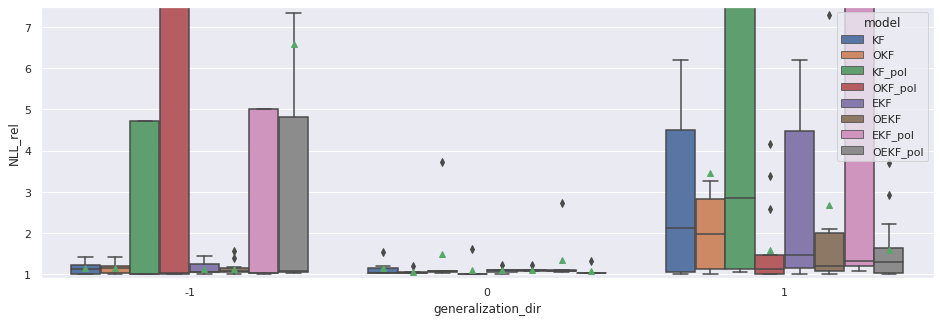

In [25]:
plt.figure(figsize=(16,5))
sns.boxplot(data=gres, y='NLL_rel', x='generalization_dir', hue='model', showmeans=True)
plt.ylim((0.9,7.5));

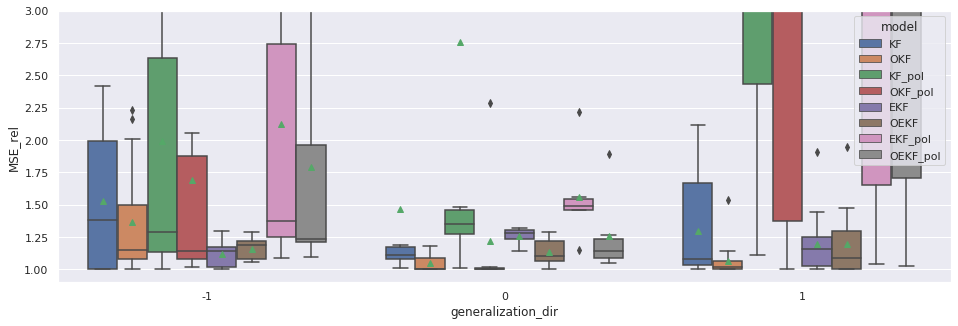

In [26]:
plt.figure(figsize=(16,5))
sns.boxplot(data=gres, y='MSE_rel', x='generalization_dir', hue='model', showmeans=True)
plt.ylim((0.9,3));

Optimized KF vs. Estimated KF per trained-scenario and tested-scenario (optimization is better $\Leftrightarrow$ value > 1):

In most cases it seems that optimization generalizes better than estimation - especially when generalizing to more complex scenarios (the cells above the diagonal in the figures). However, this phenomenon is not definite.

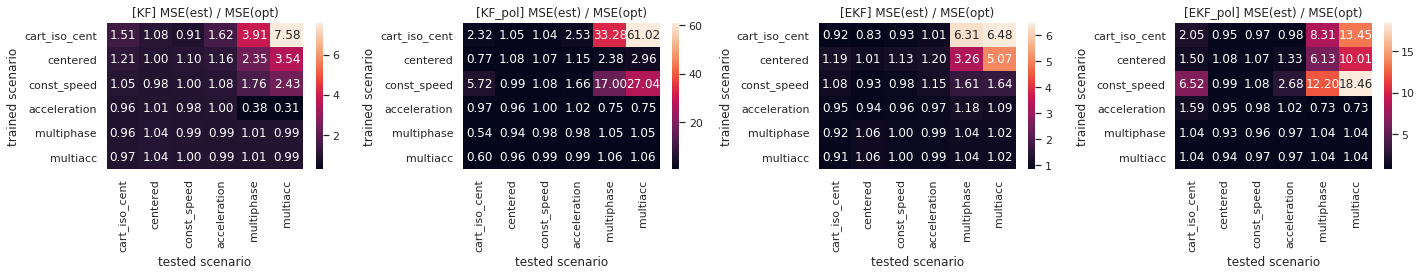

In [29]:
axs = utils.Axes(4,4,(5,4))
for m in range(4):
    ax = axs[m]
    sns.heatmap(MSE[2*m,:,:]/MSE[2*m+1,:,:], annot=True, fmt='.2f', ax=ax)
    utils.labels(ax, 'tested scenario', 'trained scenario', f"[{models_args[2*m]['title']}] MSE(est) / MSE(opt)", 12)
    ax.set_xticklabels(scenarios, rotation=90)
    ax.set_yticklabels(scenarios, rotation=0)
plt.tight_layout()

# Optimized $R$ vs. optimized $Q$

In the main benchmark (*multiphase* scenario), it seems that **both optimizations of $R$ and of $Q$ are valuable to the performance**. Optimization of $R$ seems to be more dominant in MSE improvement, and optimization of $Q$ in NLL.

These results were *not* verified widely over different scenarios and initial weights.

In [4]:
models_args = (
    dict(load=False, title='KF', no_acc=True),
    dict(load=False, title='ORKF', no_acc=True, const_R=False),
    dict(load=False, title='OQKF', no_acc=True, const_Q=False),
    dict(load=False, title='OKF', no_acc=True, const_Q=False, const_R=False),
)

model_names = [a['title'] for a in models_args]

gc.collect()

2172


multiphase
Waiting for trainings...
Waiting for processes...
Done.	(318 [s])
Best validation losses:
	KF: inf (KF_s00)
	ORKF: 122 (ORKF_s00)
	OQKF: 124 (OQKF_s00)
	OKF: 121 (OKF_s00)
4 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(21 [s])


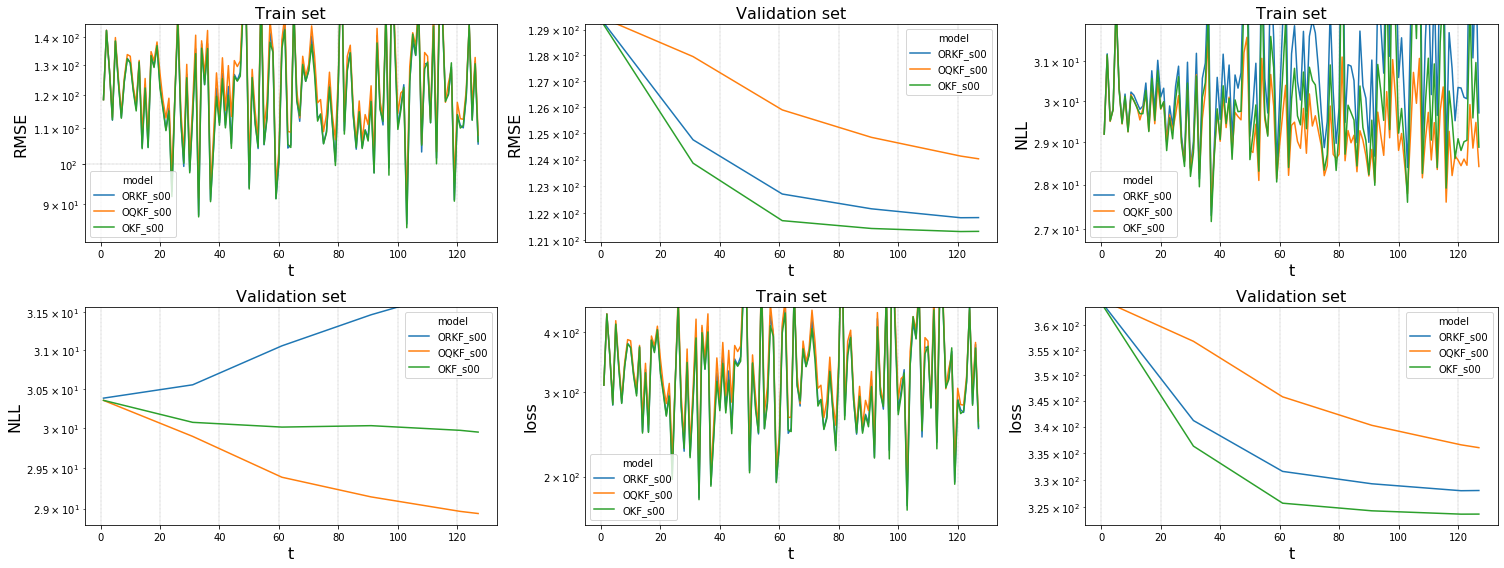

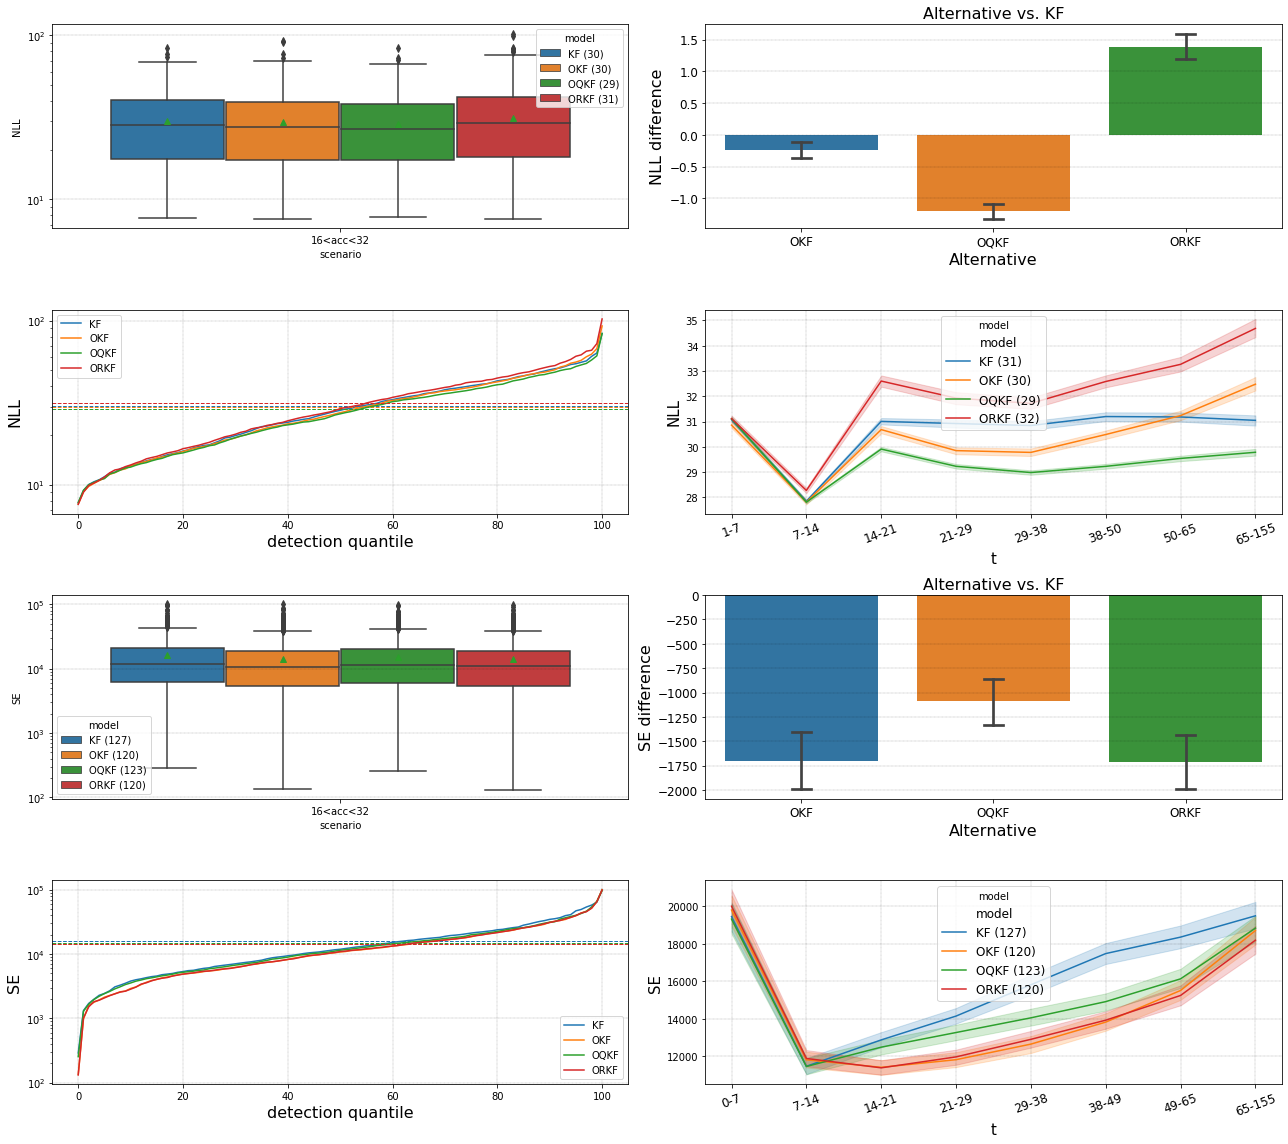

In [5]:
scenario = 'multiphase'
res = PLAB.multi_scenario_test([scenario], models_args)

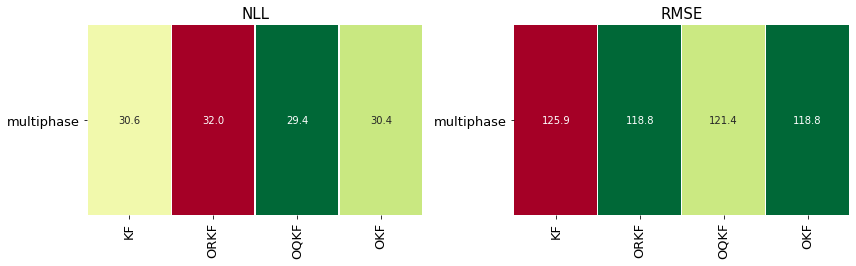

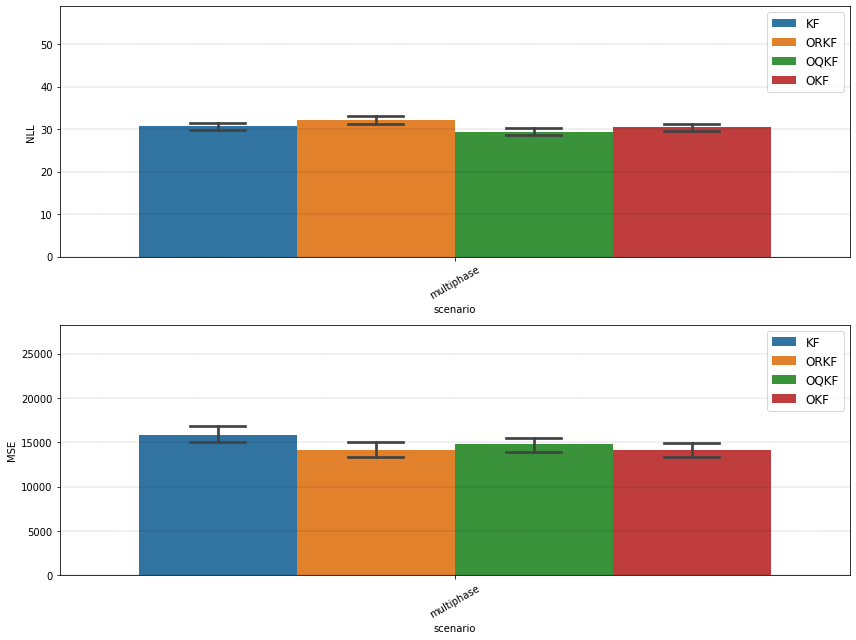

In [7]:
axs = PLAB.multi_scenario_analysis(res, scenarios=[scenario], models=('KF','ORKF','OQKF','OKF'), hetro_models=False);